In [1]:
import os
import numpy
import gzip
import pandas
import matplotlib.pyplot as plt

from data_loading import extract_peaks

In [46]:
expt_name = "stranded"
run = 1

timestamp = "2022-08-16_21-29-37"   # change this to the timestamp for your best model

in_window = 2114
out_window = 1000


proj_root = "/users/kcochran/projects/drosophila_procap/"
sequence_path = proj_root + "refs/genome.fasta"

val_peak_path = proj_root + "/data/overlap_peaks.val.bed.gz"
plus_bw_path = proj_root + "/data/bothreps.bowtie2.filtered.uniq.pos.bigWig"
minus_bw_path = proj_root + "/data/bothreps.bowtie2.filtered.uniq.neg.bigWig"

val_save_dir = proj_root + "model_out/" + expt_name + "/"
pred_counts_path = val_save_dir + timestamp + "_run" + str(run) + "_val.counts.npy"
pred_profiles_path = val_save_dir + timestamp + "_run" + str(run) + "_val.profs.npy"
metrics_path = val_save_dir + timestamp + "_run" + str(run) + "_metrics.tsv"

In [50]:
_, true_profiles = extract_peaks(sequence_path, 
                             plus_bw_path, minus_bw_path, val_peak_path,
                             in_window, out_window,
                             max_jitter=0, verbose=True)

true_profiles[true_profiles > 5452.0] = 5452.0

true_counts = true_profiles.sum(axis=2)
true_logcounts = numpy.log1p(true_counts)

Reading FASTA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13.88it/s]
Loading Peaks: 4117it [00:04, 889.66it/s]


## Plot True vs. Predicted Counts

In [51]:
pred_logcounts = numpy.load(pred_counts_path).squeeze()

In [57]:
pearson_r = numpy.corrcoef(pred_logcounts.flatten(), true_logcounts.flatten())[0,1]
print(pearson_r)

0.5901629636908768


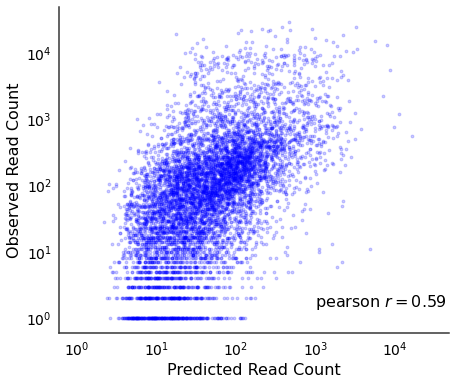

In [62]:
plot_params = {
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
}
plt.rcParams.update(plot_params)

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,6))
plt.scatter(numpy.exp(pred_logcounts), true_counts, alpha = 0.2, s = 8, color="blue")
plt.semilogy()
plt.semilogx()

max_lim = max(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1])
min_lim = min(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0])
plt.xlim(min_lim, max_lim)
plt.ylim(min_lim, max_lim)

plt.xlabel("Predicted Read Count", fontsize=16)
plt.ylabel("Observed Read Count", fontsize=16)

# you will need to manually adjust the x-y coordinates here
plt.text(1e3, 1.5, r'pearson $r = %0.2f$' % pearson_r, fontsize=16)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
plt.show()

## Plot True vs. Predicted Profiles

In [63]:
def load_coords(peak_bed):
    if peak_bed.endswith(".gz"):
        with gzip.open(peak_bed) as f:
            lines = [line.decode().split() for line in f]
    else:
        with open(peak_bed) as f:
            lines = [line.split() for line in f]

    coords = [(line[0], int(line[1]), int(line[2])) for line in lines]
    return coords
    
coords = load_coords(val_peak_path)

In [64]:
metrics_df = pandas.read_csv(metrics_path, sep="\t", header=0)

/users/kcochran/miniconda3/envs/procap/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


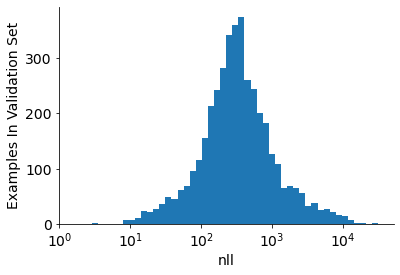

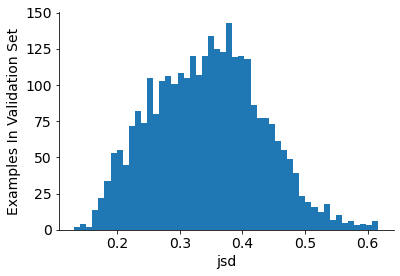

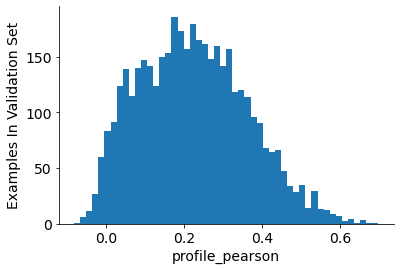

In [65]:
for metric in metrics_df.columns:
    metric_vals = metrics_df[metric]
    if metric == "nll":
        # need to plot this metric on log scale
        metric_vals = numpy.log10(metric_vals + 1)
        
    plt.hist(metric_vals, bins=50)
    plt.xlabel(metric, fontsize=14)
    
    if metric == "nll":
        plt.gca().set_xticklabels([r'$10^{' + str(int(i)) + r'}$' for i in plt.gca().get_xticks()])
    
    plt.ylabel("Examples In Validation Set", fontsize=14)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()

In [66]:
pred_profiles = numpy.load(pred_profiles_path)
pred_profiles = numpy.exp(pred_profiles)  # because these were saved after log_softmax

In [67]:
def get_example_indexes_by_metric(metrics_df, metric_name, top_mid_bottom, n = 20):
    assert metric_name in metrics_df.columns
    assert subset in ["top", "mid", "bottom"]
    
    metrics_vals = metrics_df[metric_name]
    # sort the indexes for all examples by how well the model did
    # (technically, sort in increasing order)
    sorted_idxs = metrics_vals.argsort()
    
    if metric_name in ["profile_pearson"]:
        # for this metric only, lower is worse, so need to flip
        sorted_idxs = sorted_idxs[::-1]
    
    if subset == "top":
        # these are the indexes of the best n examples 
        example_idxs = sorted_idxs[:n]
    elif subset == "bottom":
        # these are the indexes of the worst n examples 
        example_idxs = sorted_idxs[-n:]
    else:
        # these are the indexes of the median n examples 
        half_num_examples = len(sorted_idxs) // 2
        example_idxs = sorted_idxs[half_num_examples - n // 2 : half_num_examples + n // 2 + 1]
        example_idxs = example_idxs[:n]  # todo, need to allow for odd n

    return example_idxs


ex_idxs = dict()
for subset in ["top", "mid", "bottom"]:
    ex_idxs[subset] = get_example_indexes_by_metric(metrics_df, "nll", subset)

In [68]:
plot_params = {
    "xtick.labelsize": 20,
    "ytick.labelsize": 20
}
plt.rcParams.update(plot_params)

def plot_pred_vs_true(true_profile, pred_profile,
                      prof_len = out_window,
                      title = None):
    num_subplots = 2
    
    fig = plt.figure(figsize=(20, 2 * num_subplots))
    gs = fig.add_gridspec(num_subplots, hspace=0.3, height_ratios = [1,1])
    axes = gs.subplots()
    
    if title is not None:
        fig.suptitle(title, y = 1.01, fontsize=24, horizontalalignment='left', x = 0.12)
    
    axis_fontsize = 24
    x_axis_buffer = 10
    labelpad = 80
    prof_linewidth = 3
    attr_linewidth = 2
    x_range = numpy.arange(0,prof_len)
    axes[0].plot(x_range, true_profile[0], alpha=0.8, c = "blue", linewidth=prof_linewidth)
    axes[0].plot(x_range, -1 * true_profile[1], alpha=0.5, c = "blue", linewidth=prof_linewidth)
    axes[0].set_xlim(- x_axis_buffer, prof_len + x_axis_buffer)
    axes[0].set_ylabel("\nObserved\nReads", fontsize = axis_fontsize, rotation=0, labelpad=labelpad)
    
    axes[1].plot(x_range, pred_profile[0], alpha=0.8, c = "orange", linewidth=prof_linewidth)
    axes[1].plot(x_range, -1 * pred_profile[1], alpha=0.5, c = "orange", linewidth=prof_linewidth)
    axes[1].set_xlim(- x_axis_buffer, prof_len + x_axis_buffer)
    axes[1].set_ylabel("\nPredicted\nReads", fontsize = axis_fontsize, rotation=0, labelpad=labelpad)
    
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_label_coords(-0.1,0.25)
        ax.spines['left'].set_linewidth(1.5)
        ax.tick_params(left=False)
        
    axes[0].spines['bottom'].set_visible(False)
    axes[0].set_xticks([])
    
    axes[1].spines['bottom'].set_linewidth(1.5)
    
    plt.show()

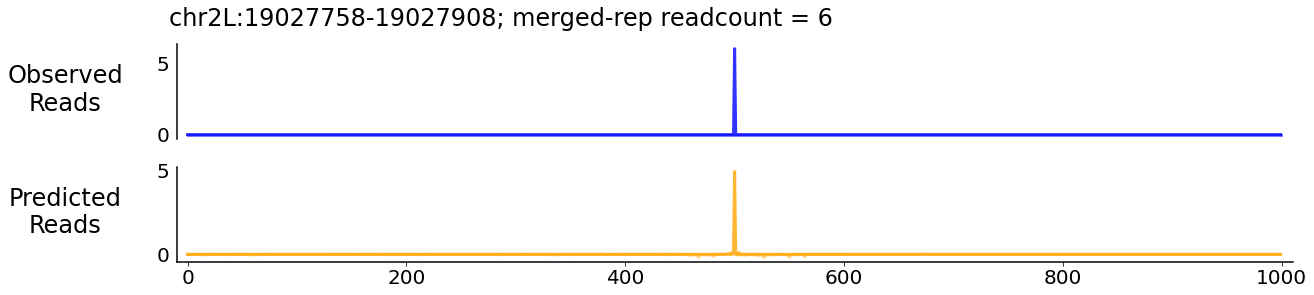

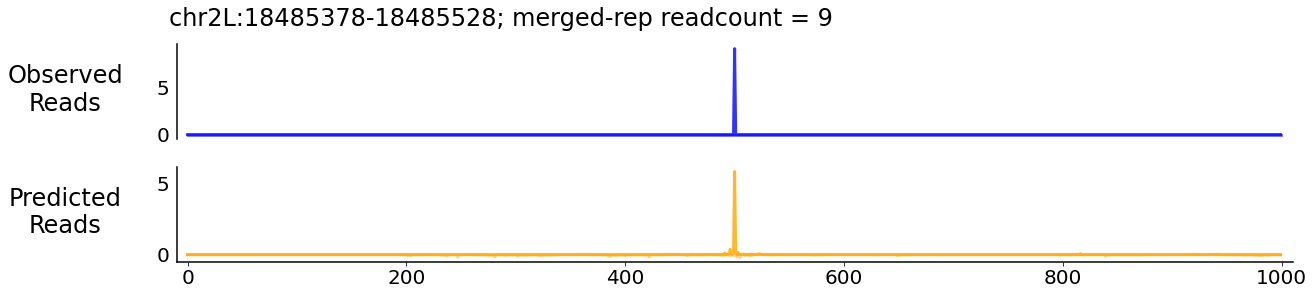

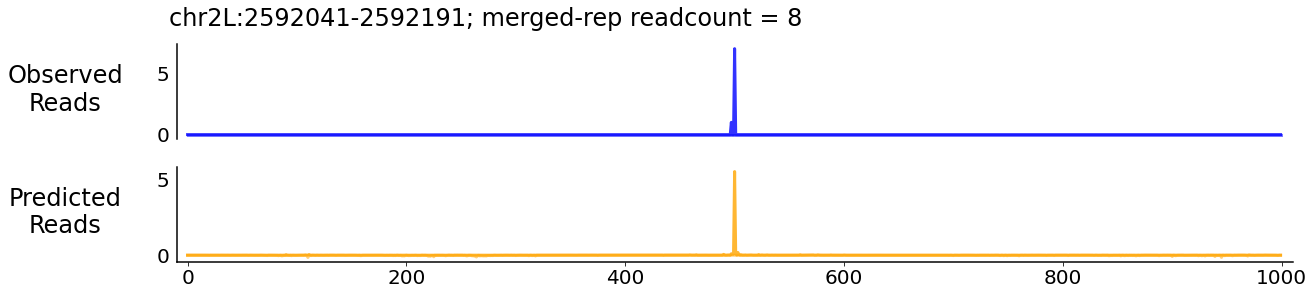

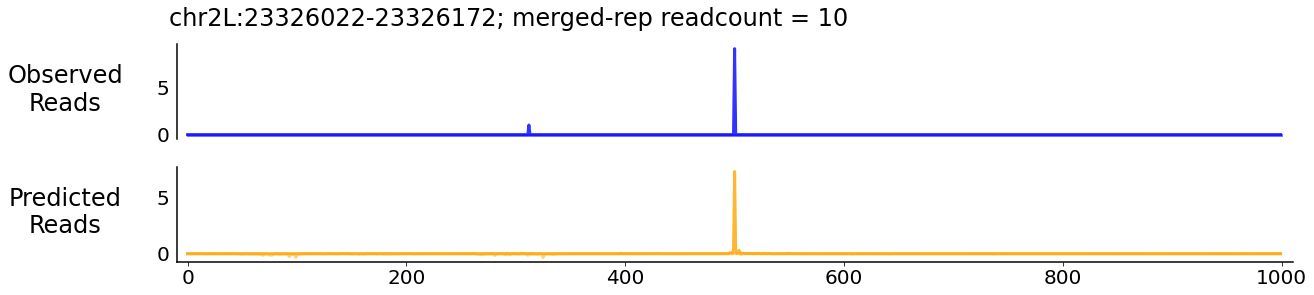

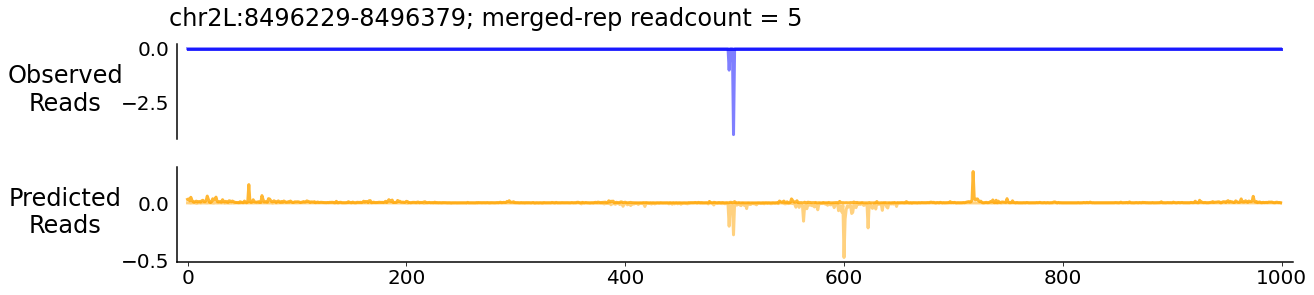

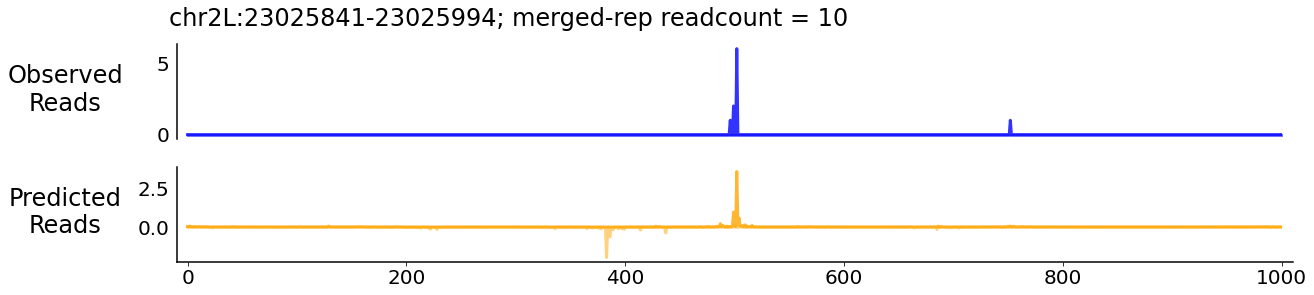

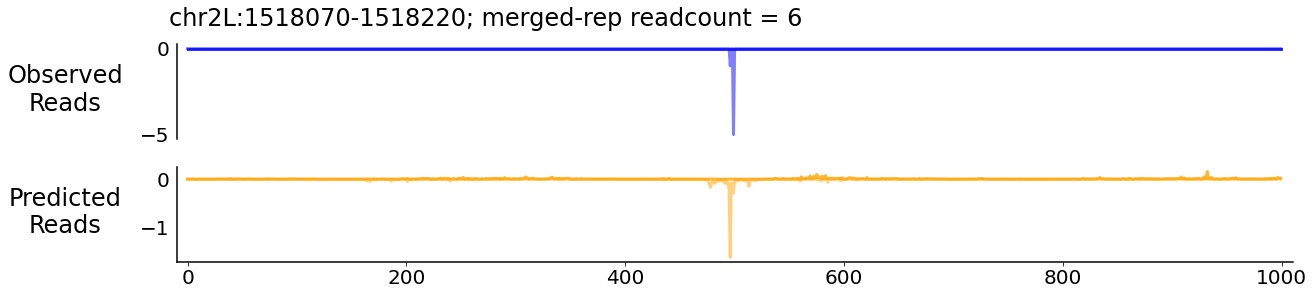

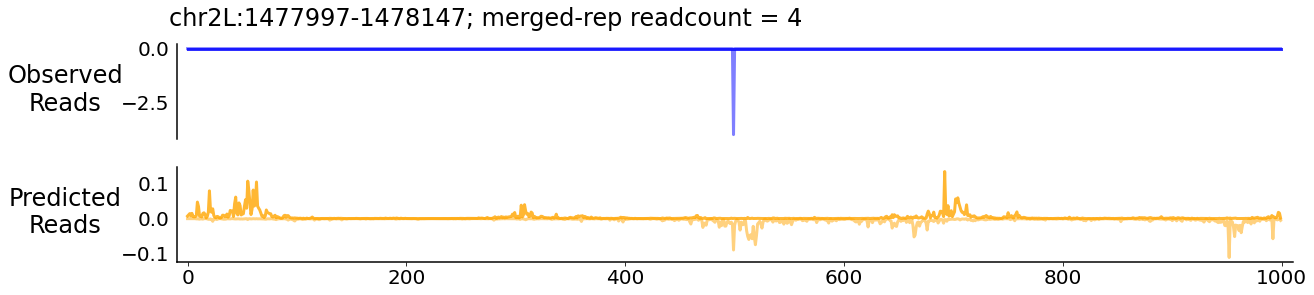

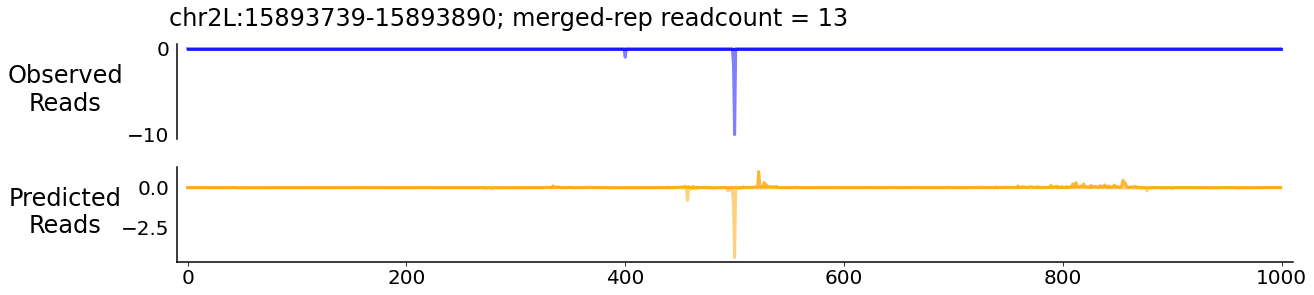

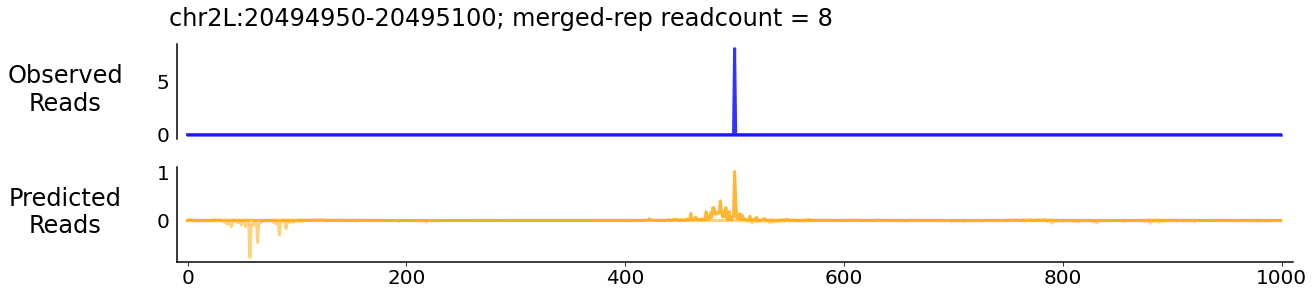

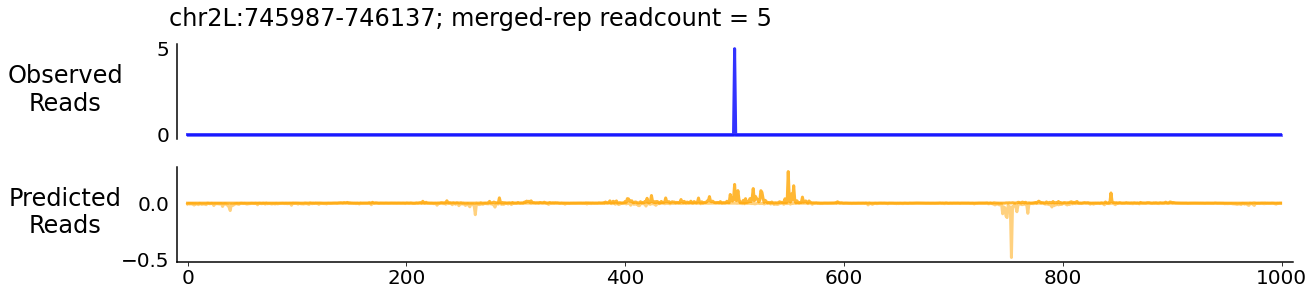

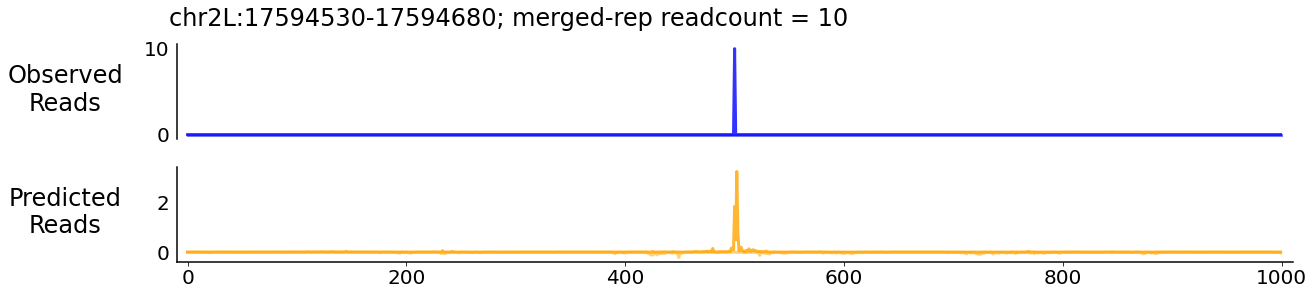

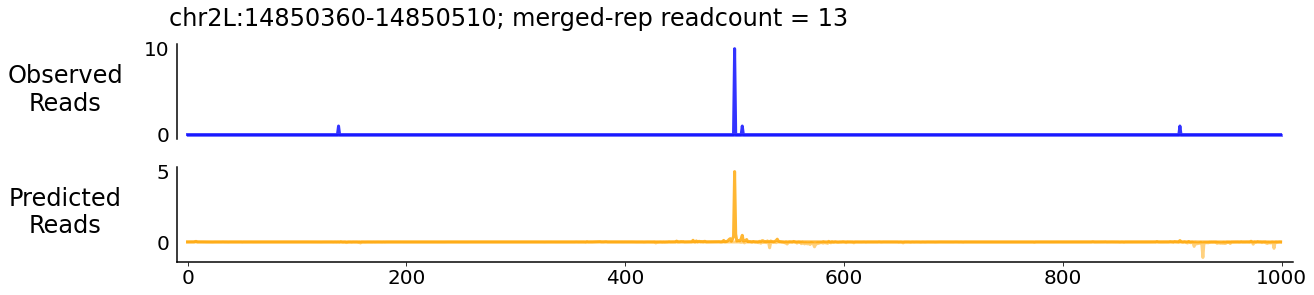

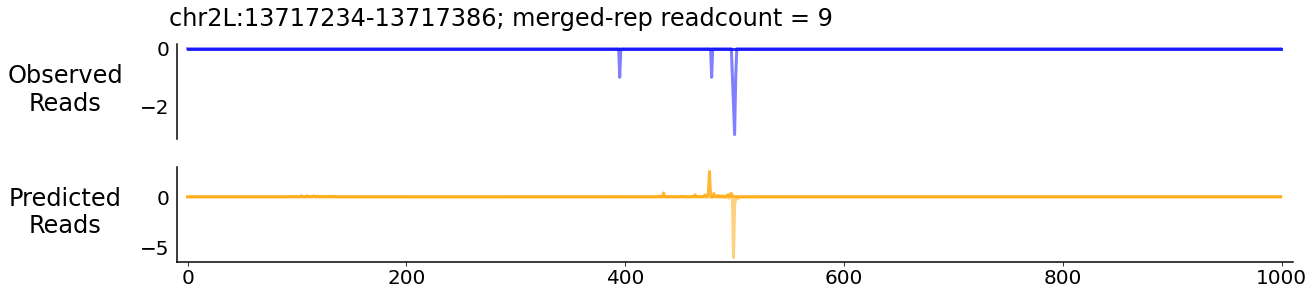

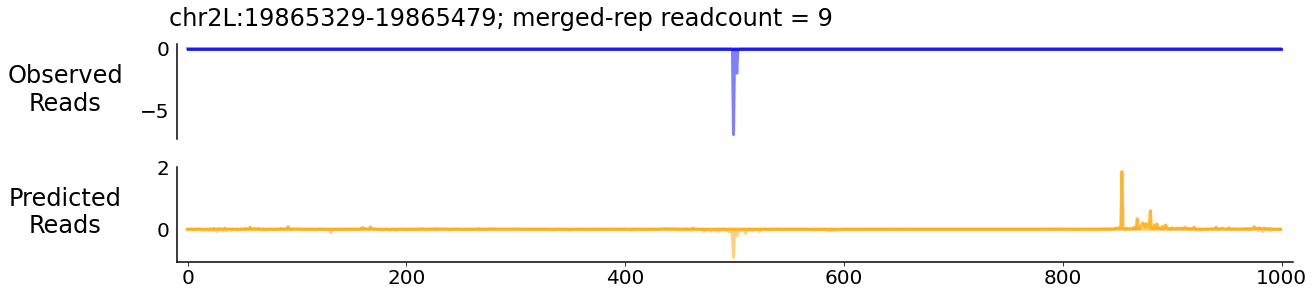

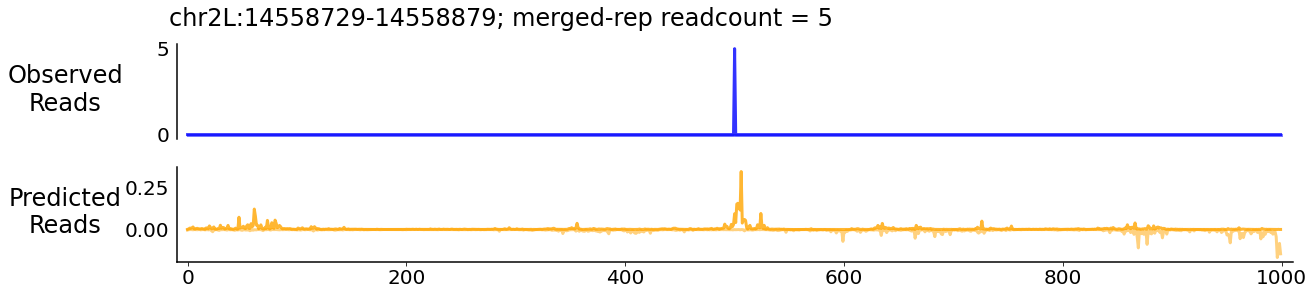

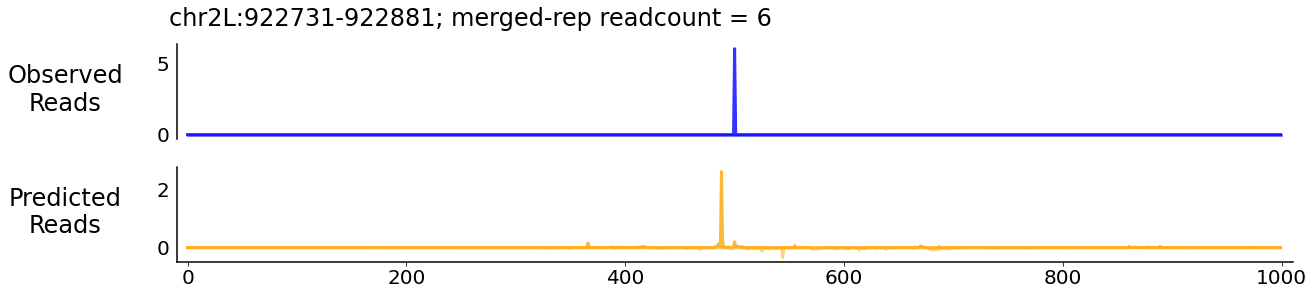

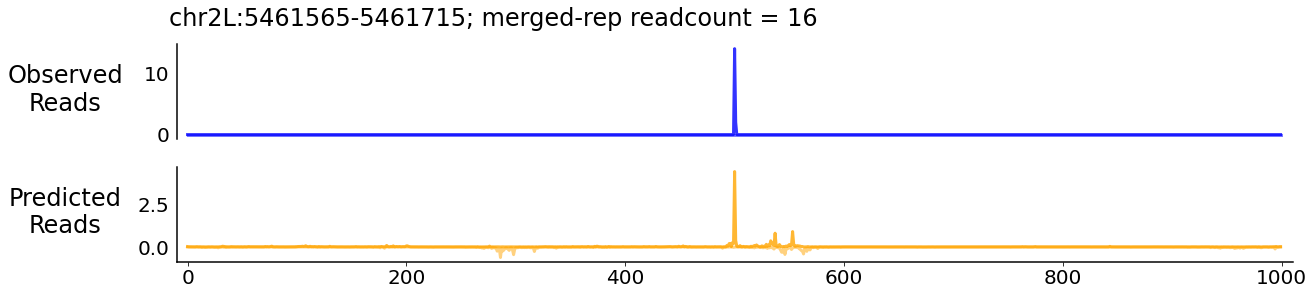

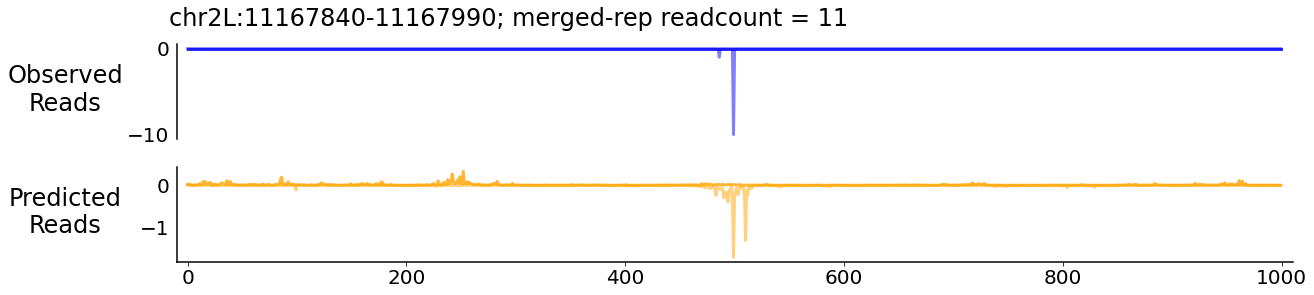

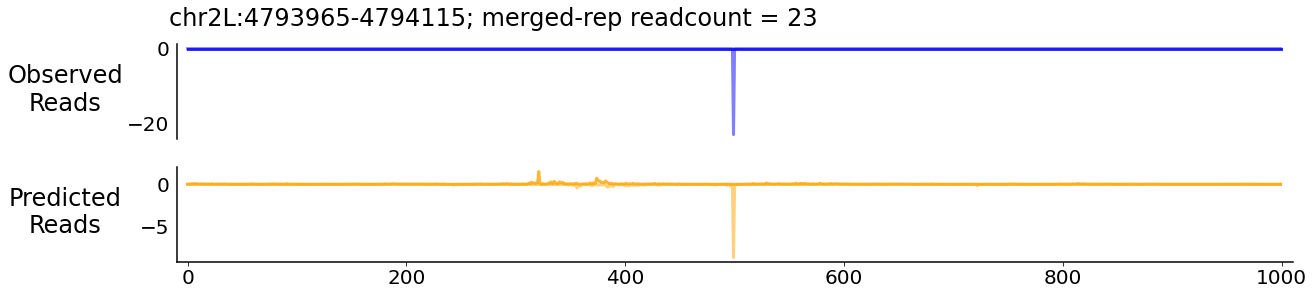

In [69]:
# First, plot some of the "best"-predicted examples

for idx in ex_idxs["top"]:
    true_profile = true_profiles[idx]
    true_count = numpy.sum(true_profile)
    
    title = coords[idx][0] + ":" + str(coords[idx][1]) + "-" + str(coords[idx][2])
    title += "; merged-rep readcount = " + str(int(true_count))
    
    pred_prof_scaled = true_count * pred_profiles[idx]

    plot_pred_vs_true(true_profile, pred_prof_scaled, title = title)

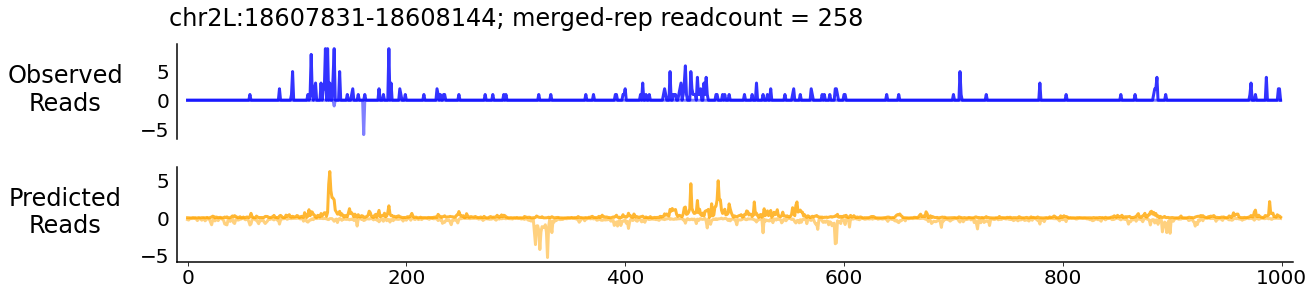

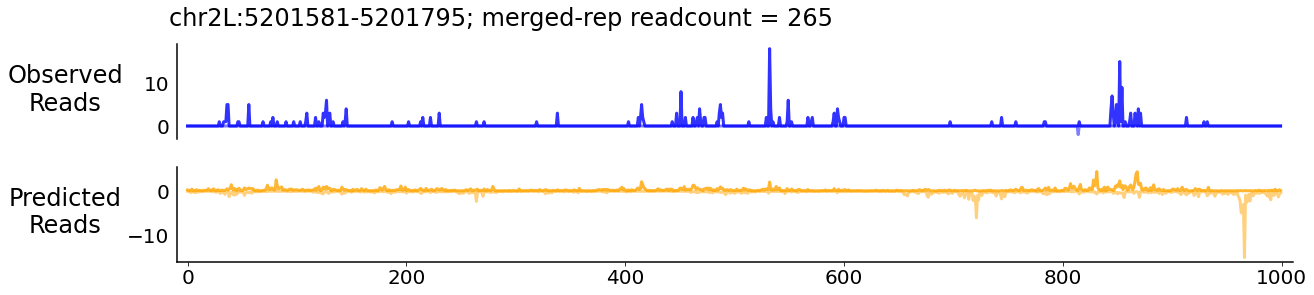

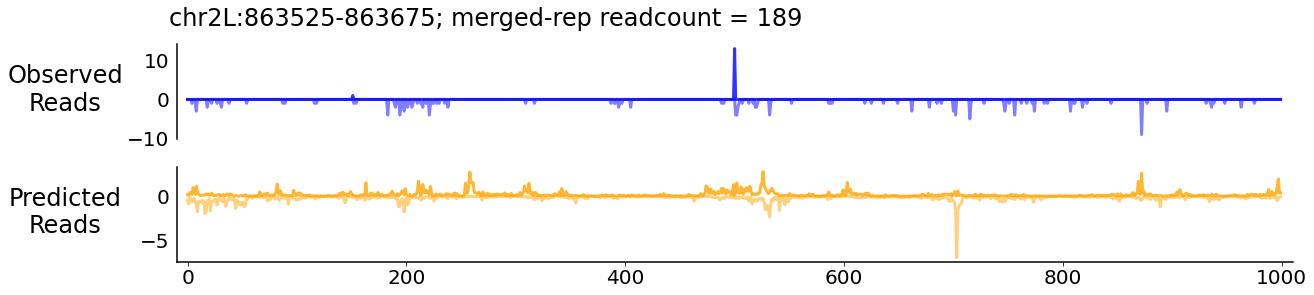

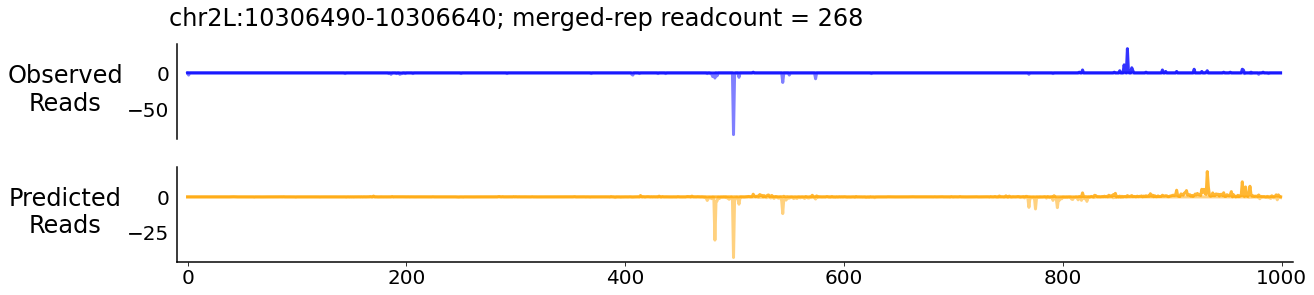

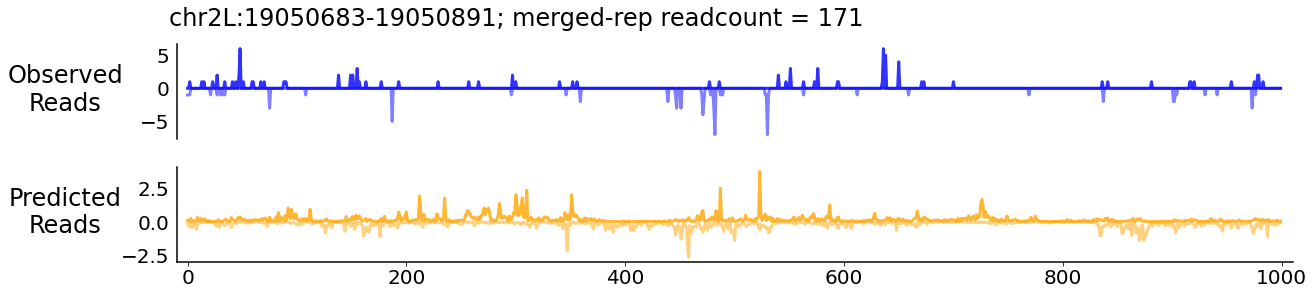

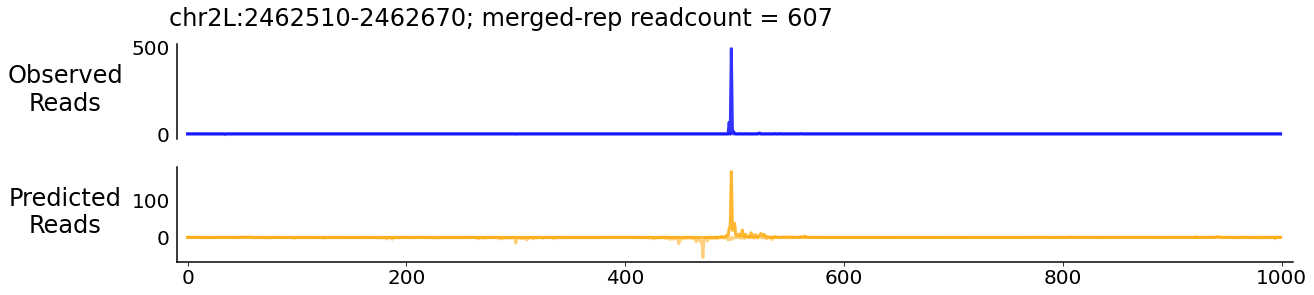

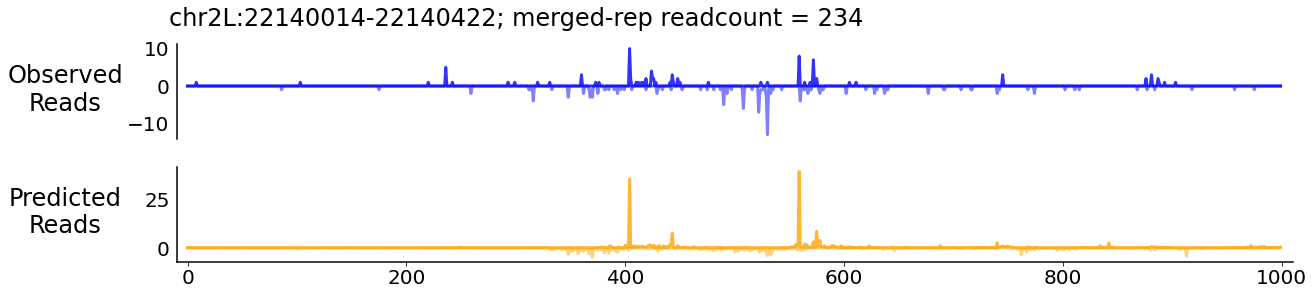

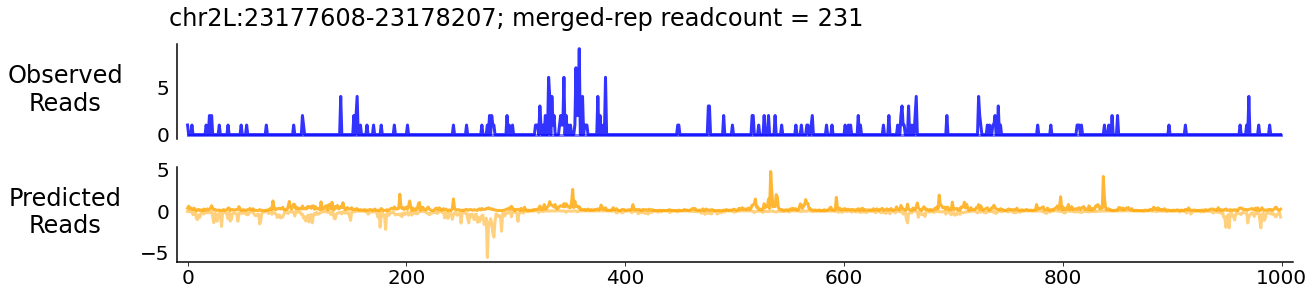

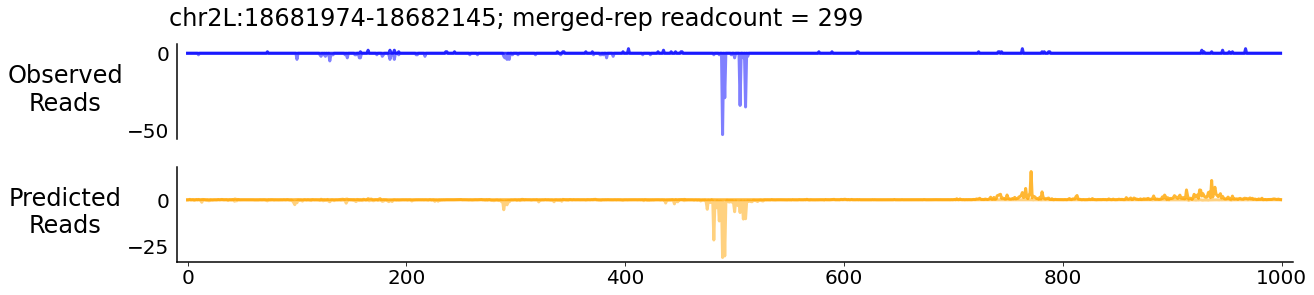

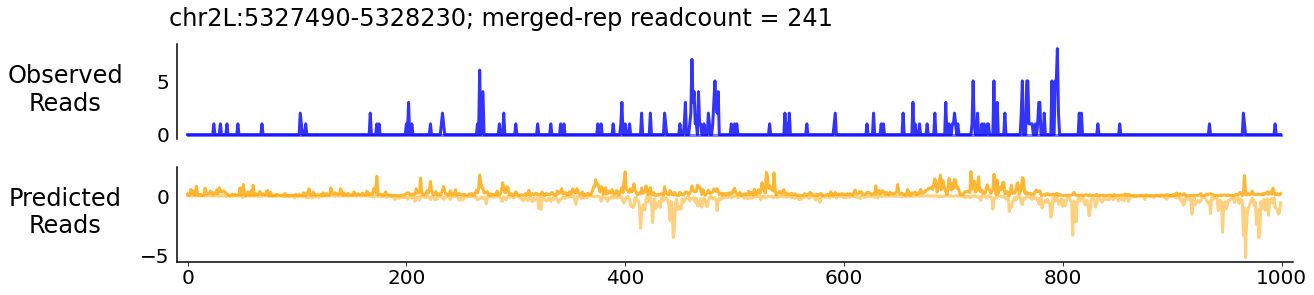

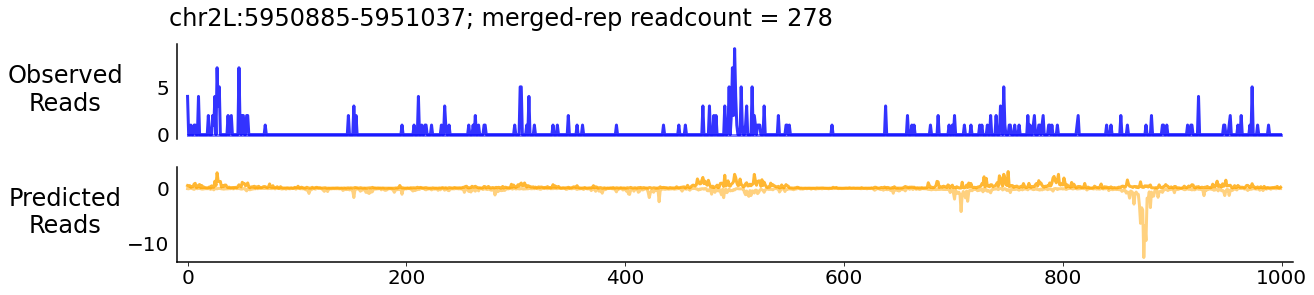

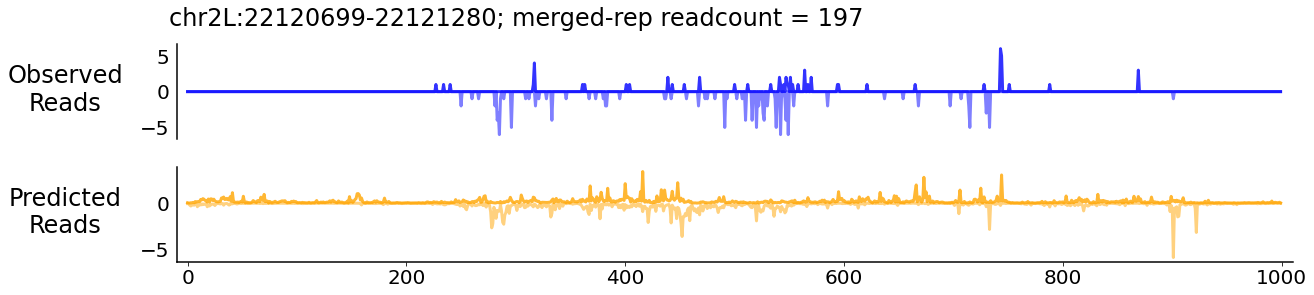

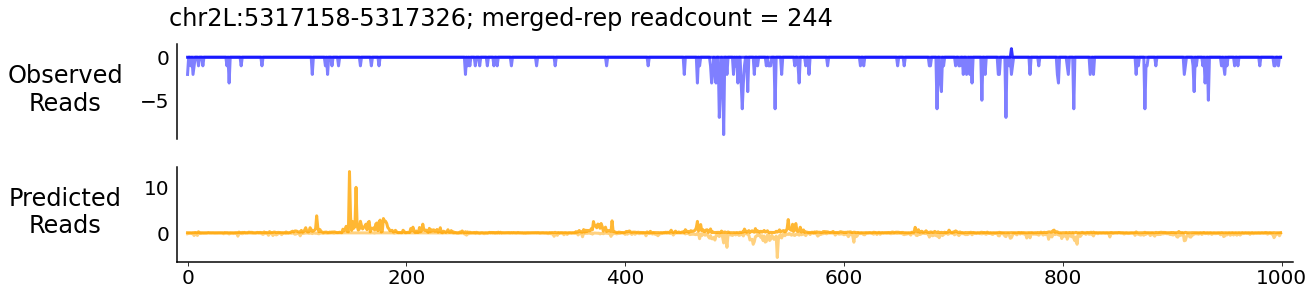

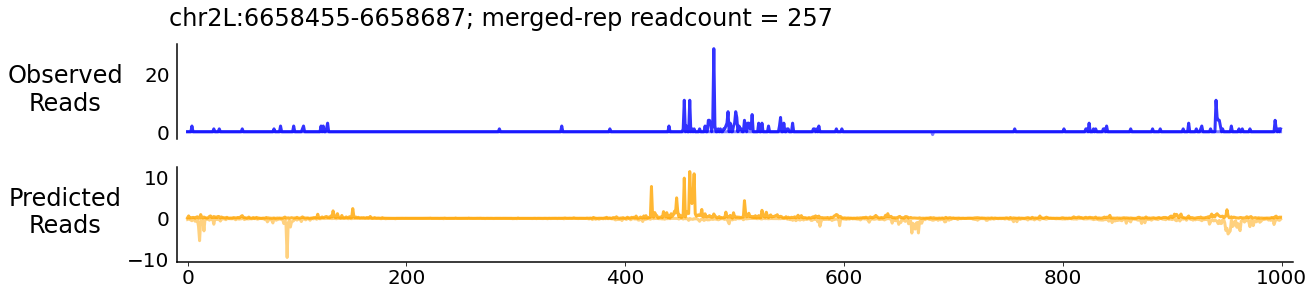

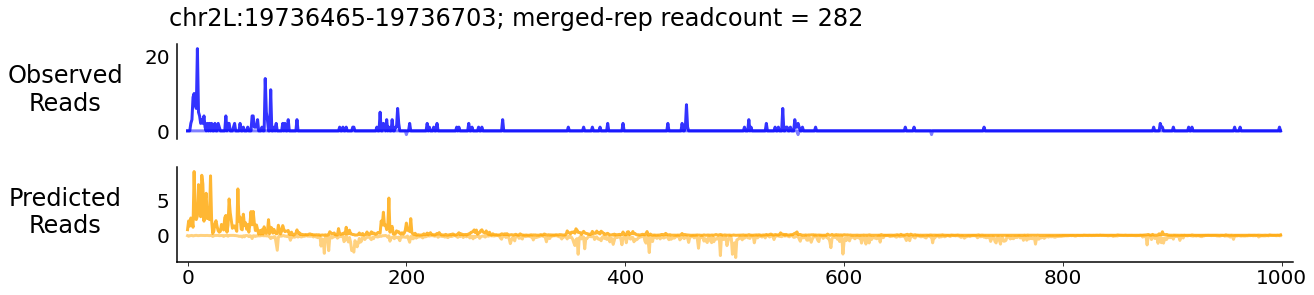

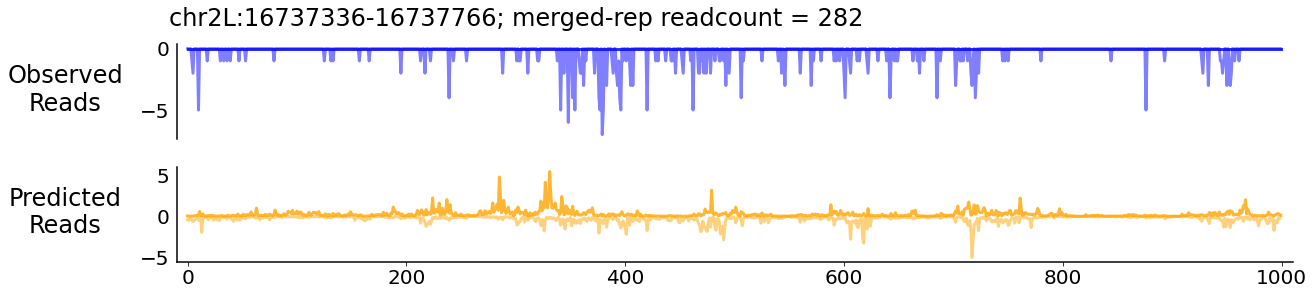

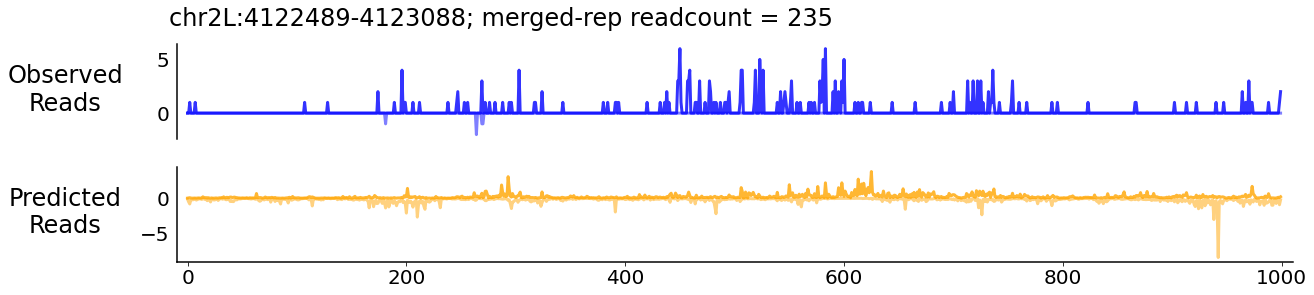

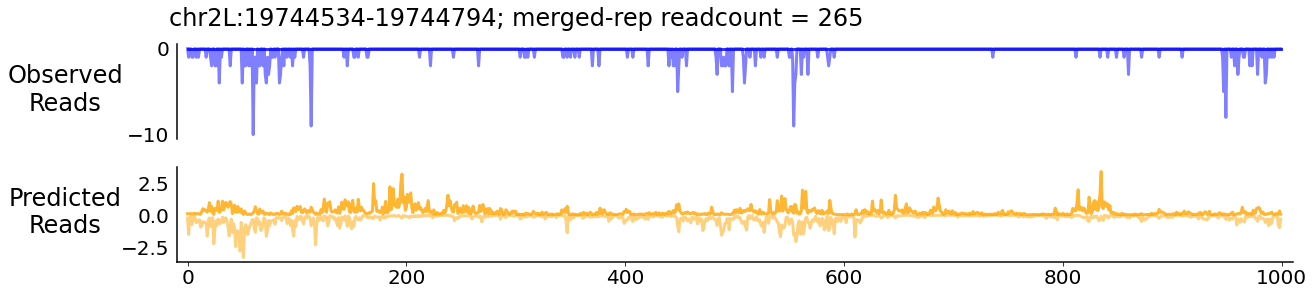

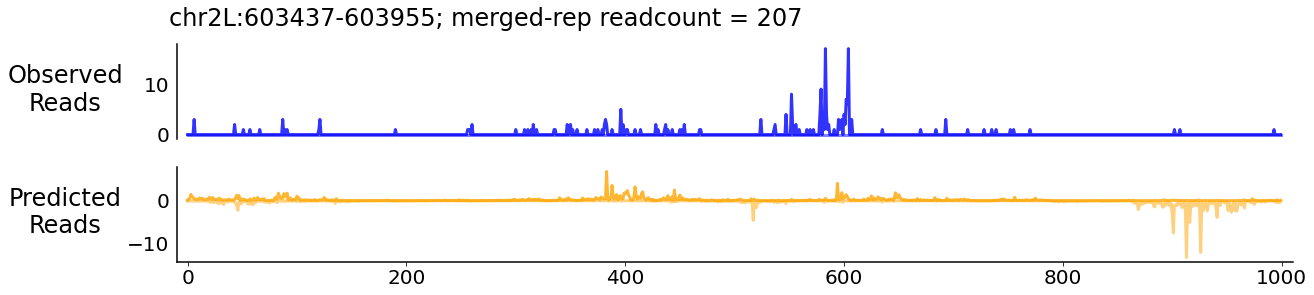

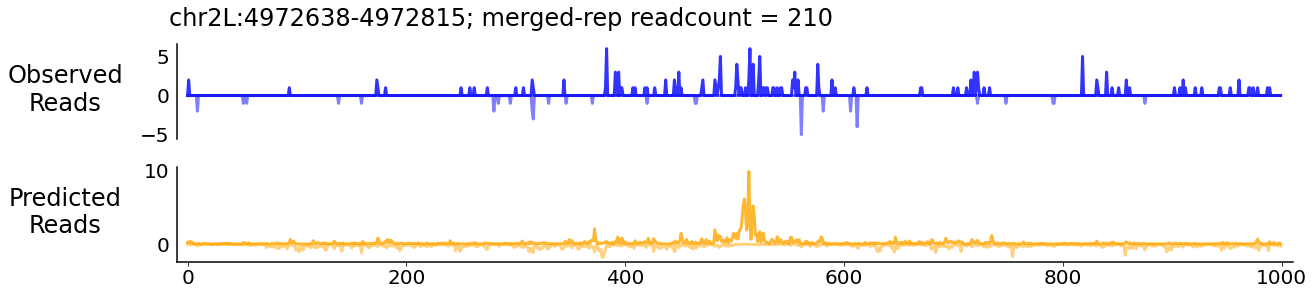

In [70]:
# Then plot some of the middling examples

for idx in ex_idxs["mid"]:
    true_profile = true_profiles[idx]
    true_count = numpy.sum(true_profile)
    
    title = coords[idx][0] + ":" + str(coords[idx][1]) + "-" + str(coords[idx][2])
    title += "; merged-rep readcount = " + str(int(true_count))
    
    pred_prof_scaled = true_count * pred_profiles[idx]

    plot_pred_vs_true(true_profile, pred_prof_scaled, title = title)

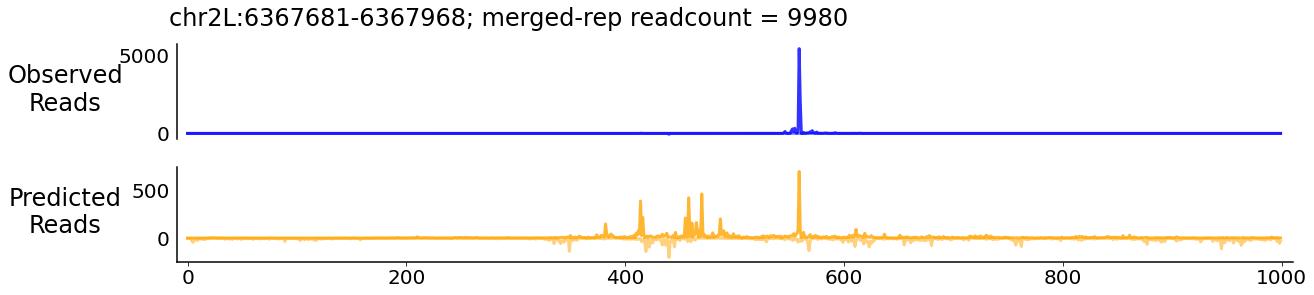

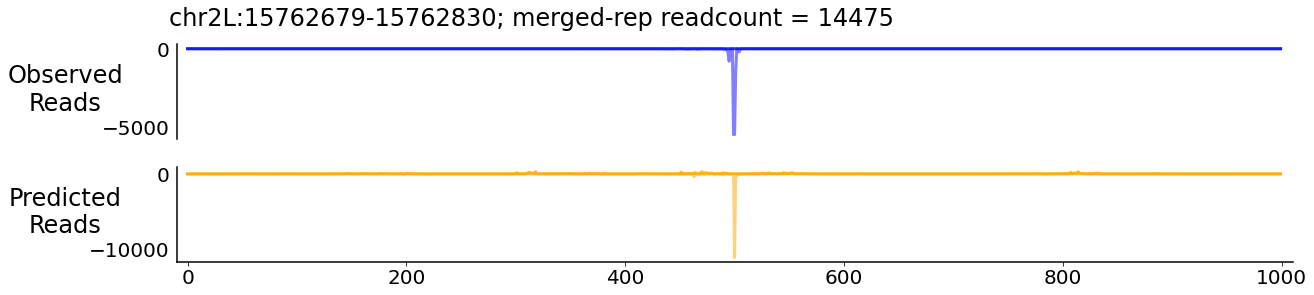

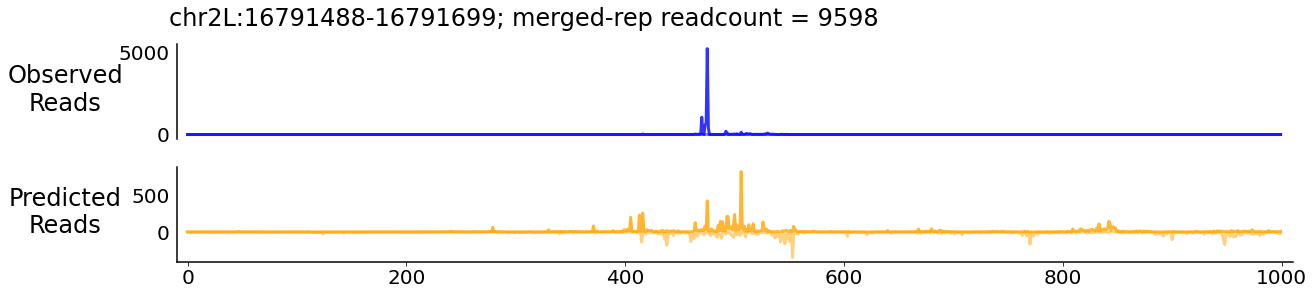

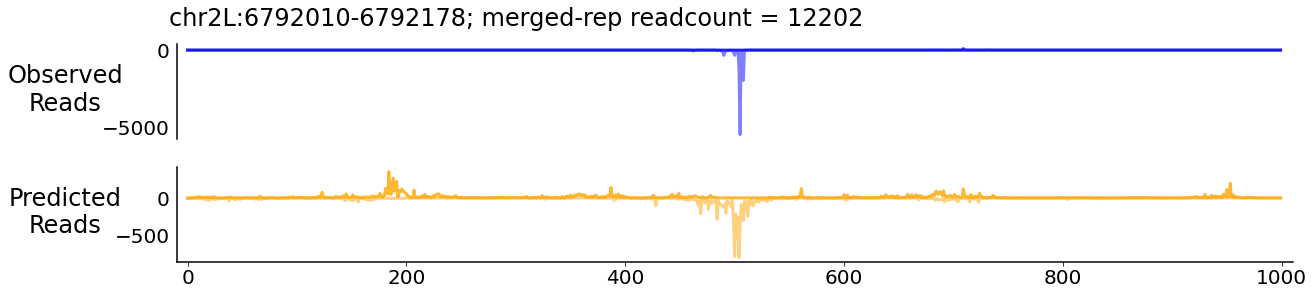

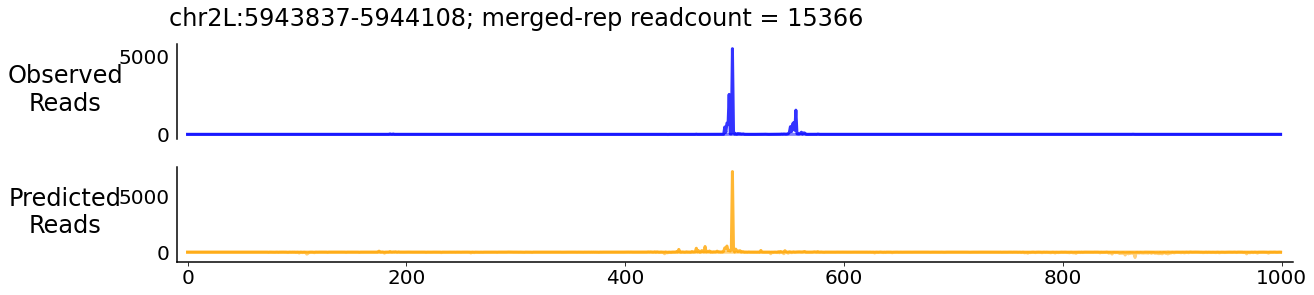

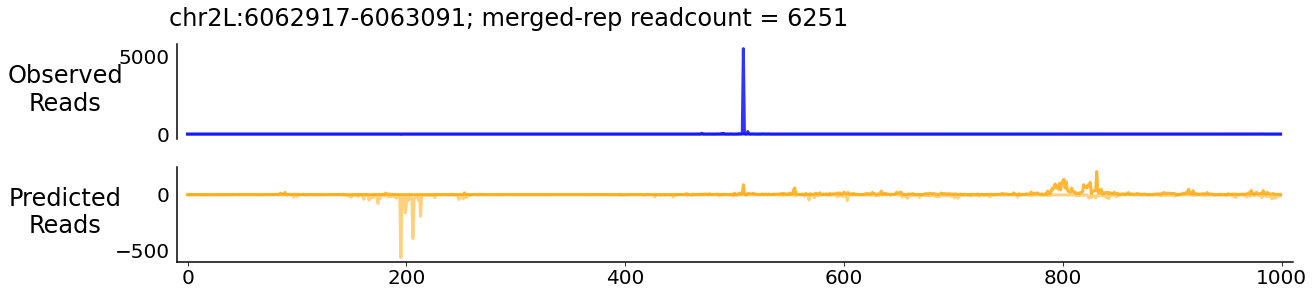

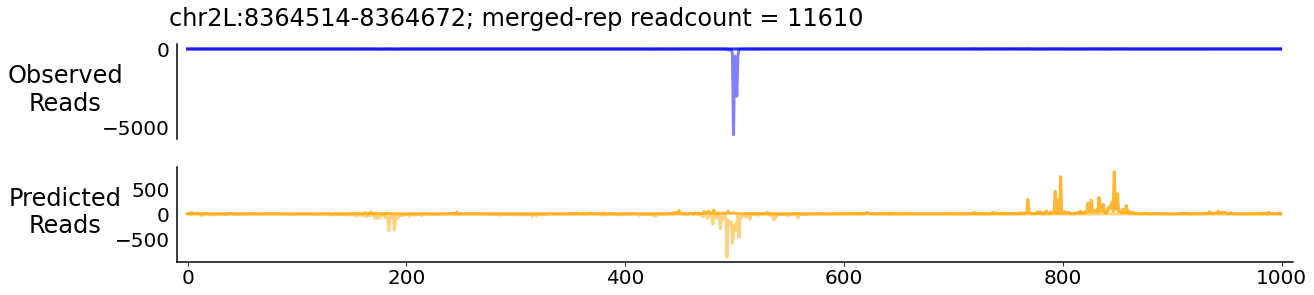

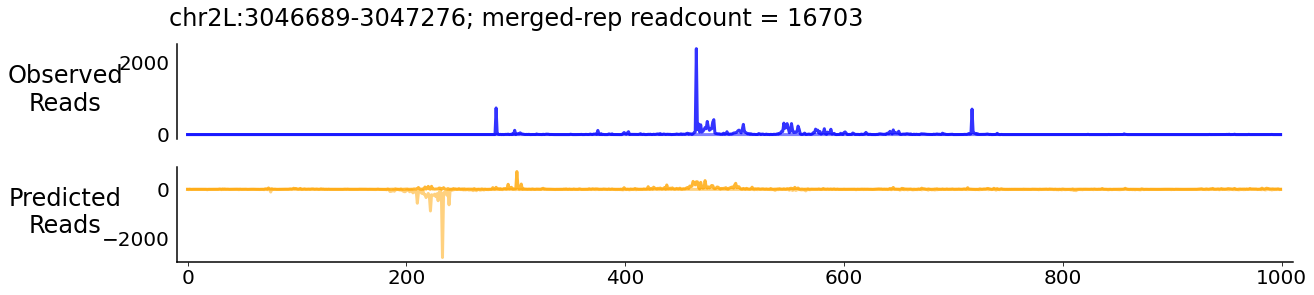

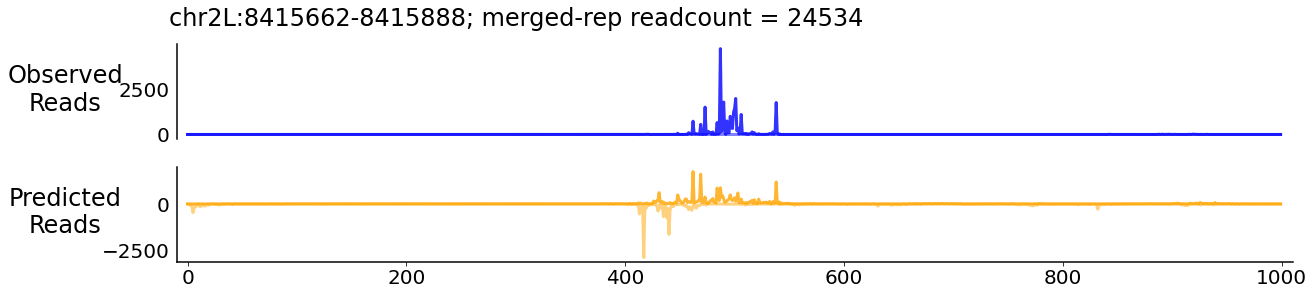

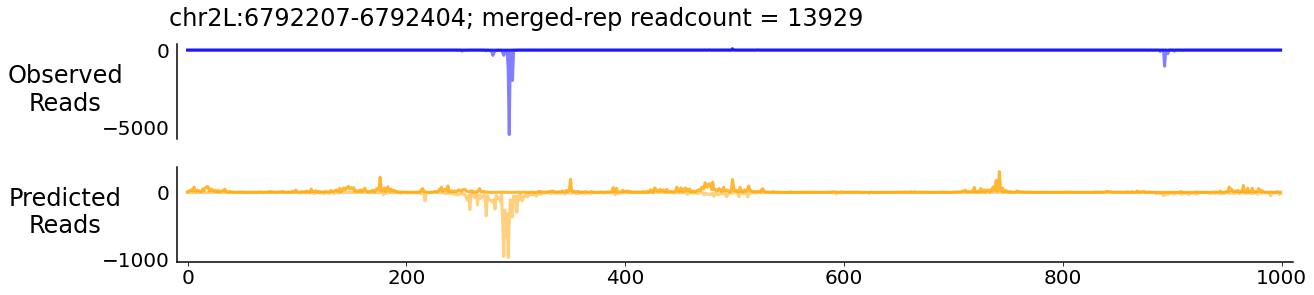

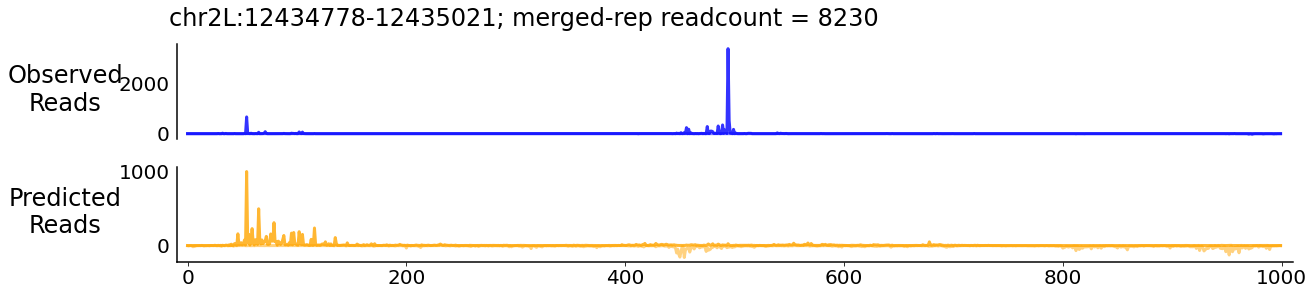

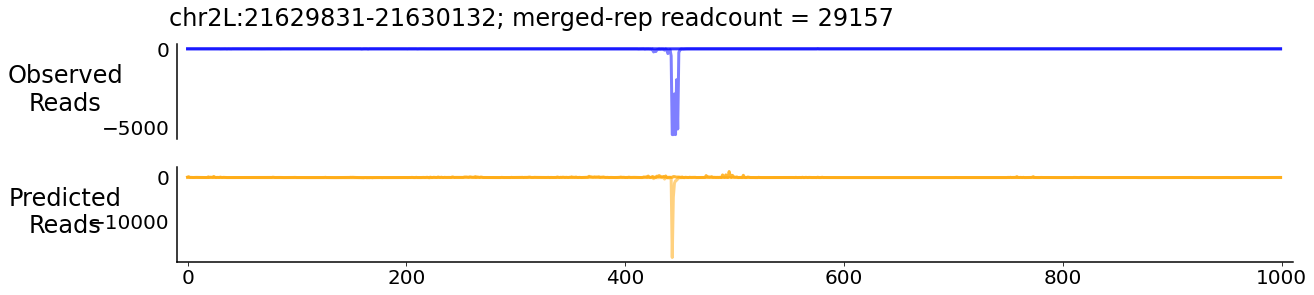

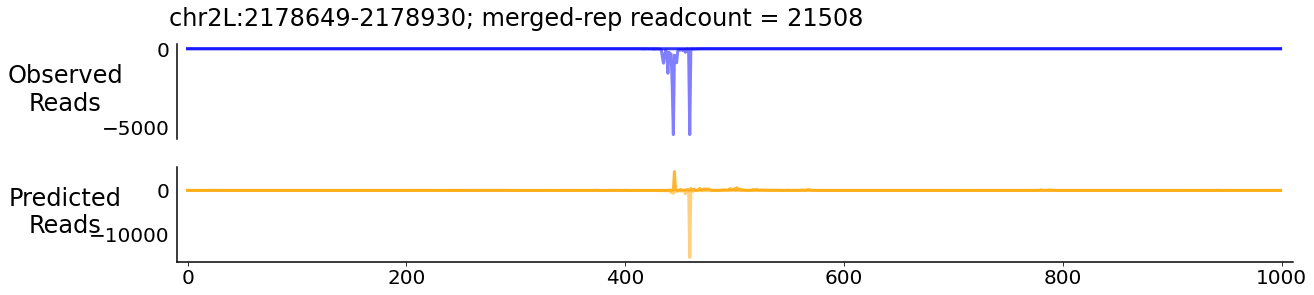

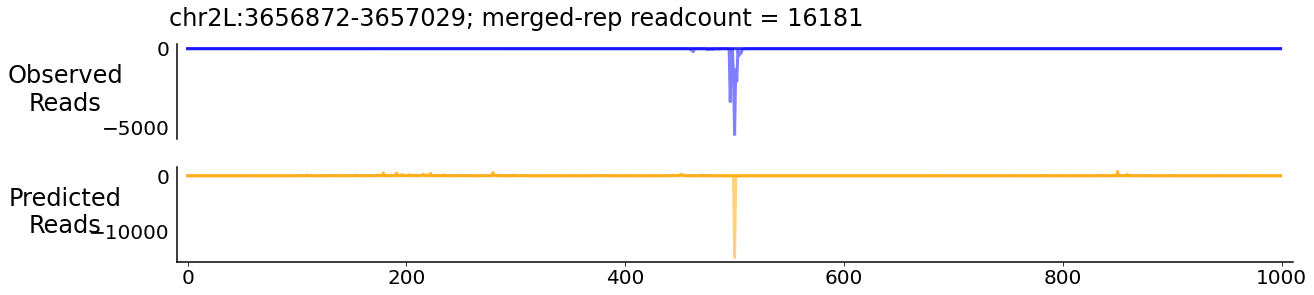

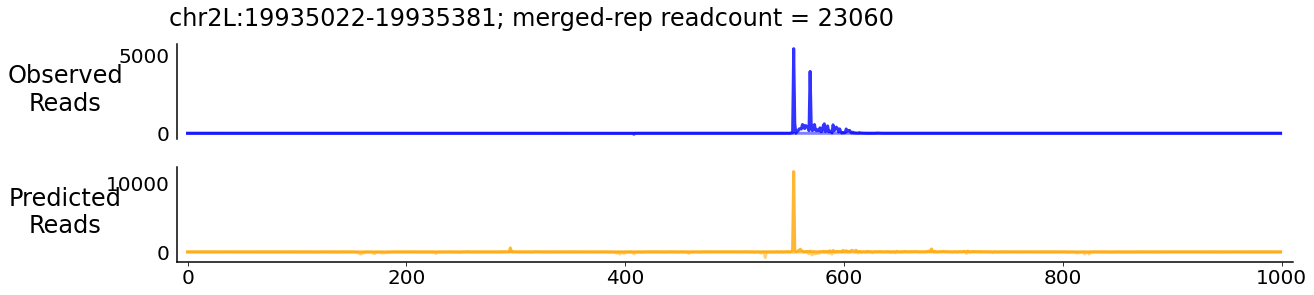

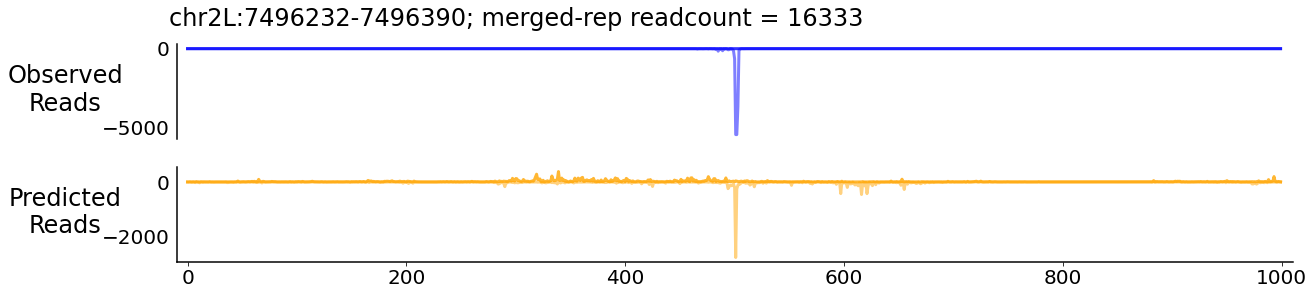

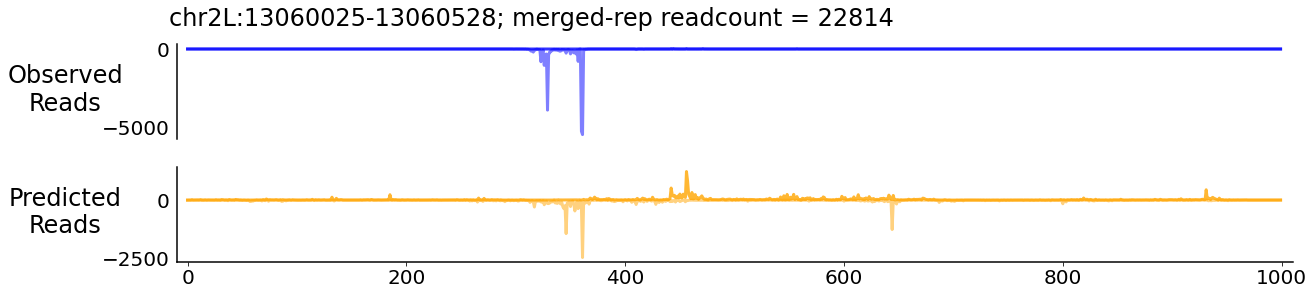

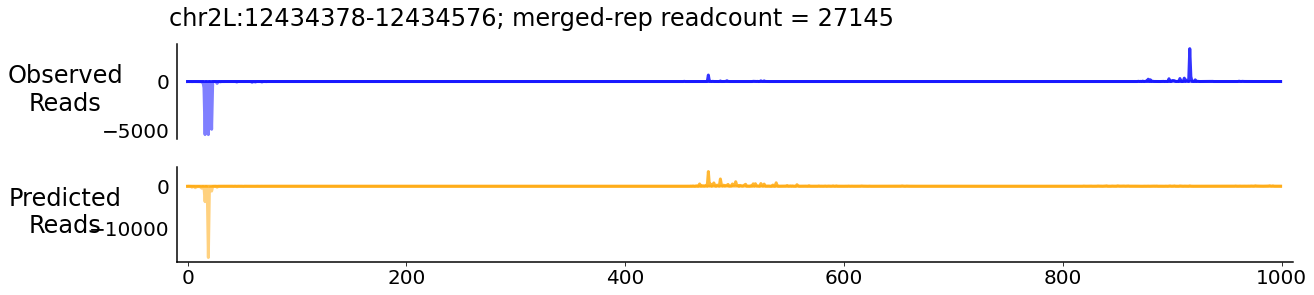

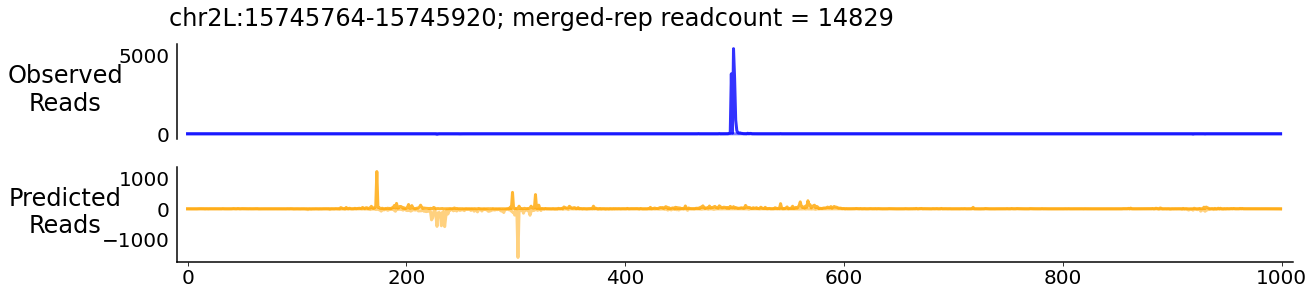

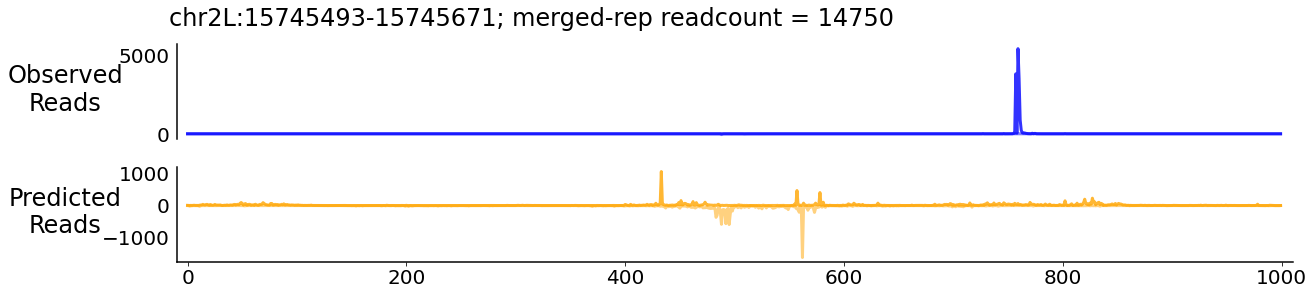

In [71]:
# And finally, plot some of the worst-predicted examples

for idx in ex_idxs["bottom"]:
    true_profile = true_profiles[idx]
    true_count = numpy.sum(true_profile)
    
    title = coords[idx][0] + ":" + str(coords[idx][1]) + "-" + str(coords[idx][2])
    title += "; merged-rep readcount = " + str(int(true_count))
    
    pred_prof_scaled = true_count * pred_profiles[idx]

    plot_pred_vs_true(true_profile, pred_prof_scaled, title = title)

In [72]:
ex_idxs_jsd = dict()
for subset in ["top", "mid", "bottom"]:
    ex_idxs_jsd[subset] = get_example_indexes_by_metric(metrics_df, "jsd", subset)

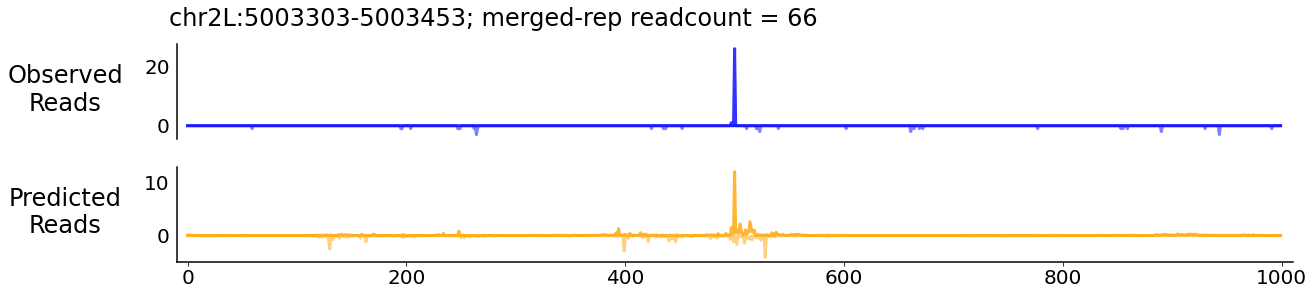

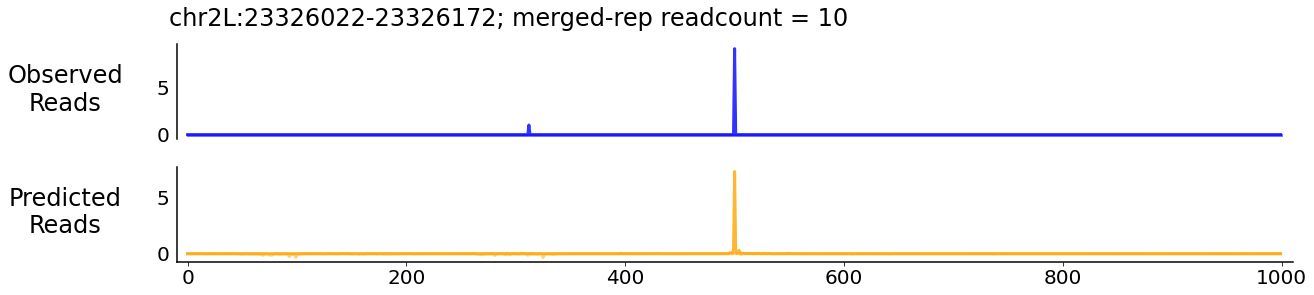

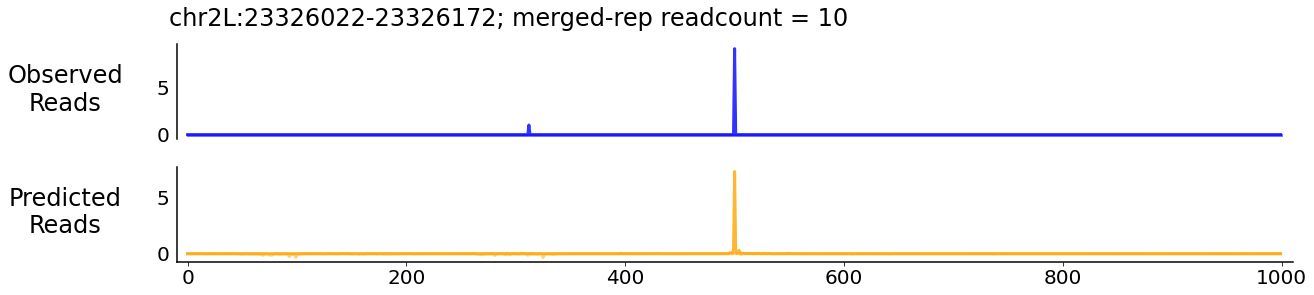

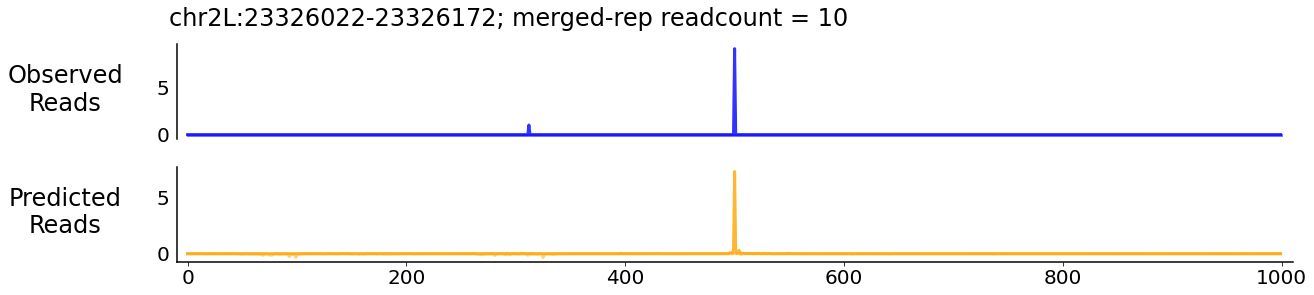

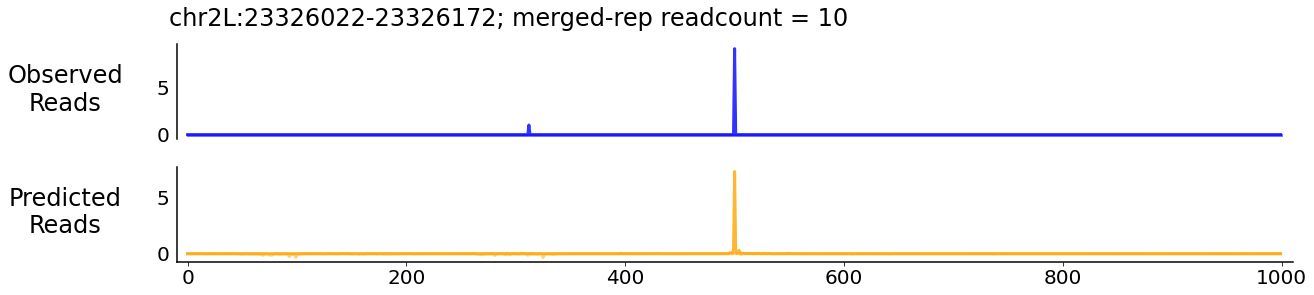

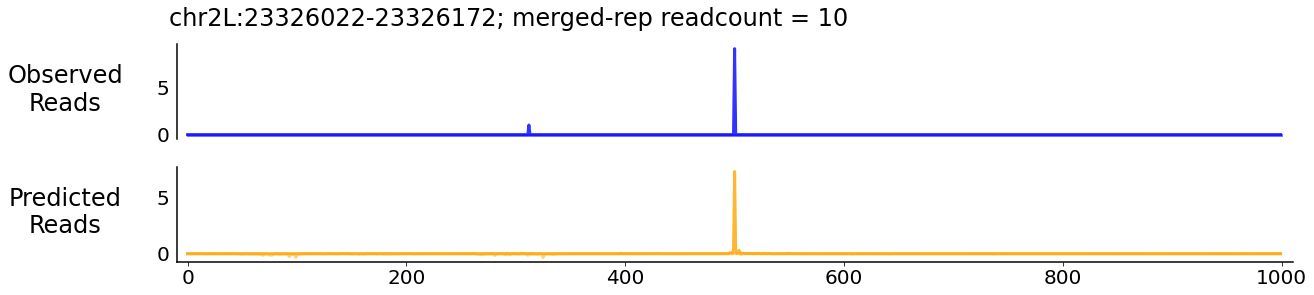

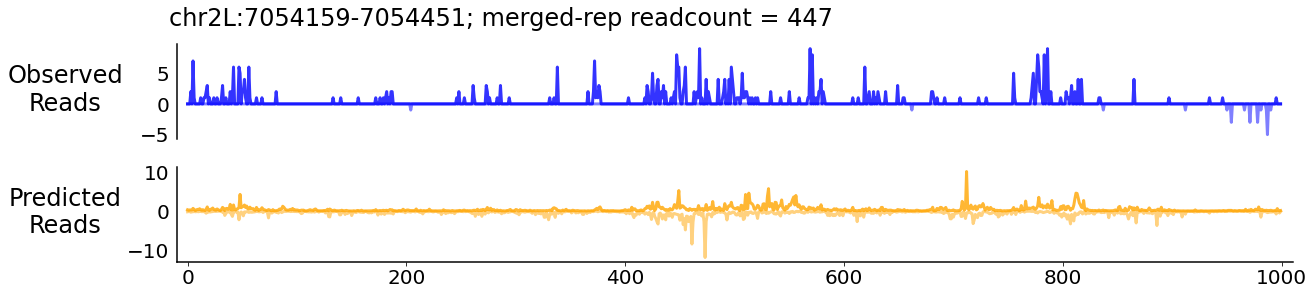

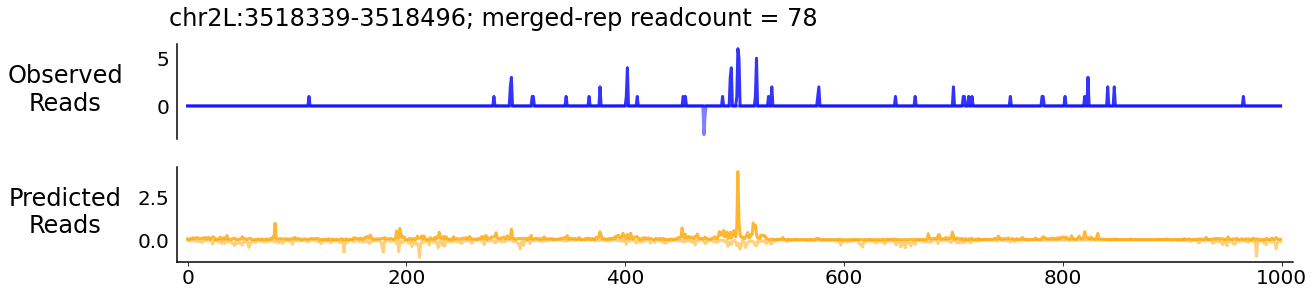

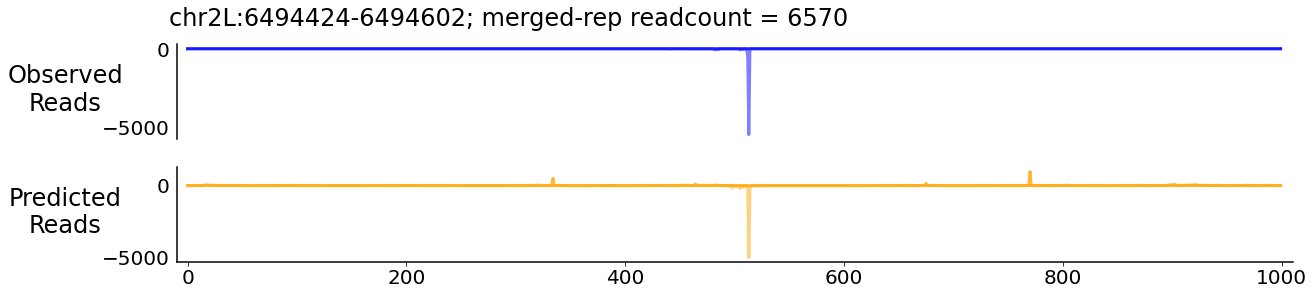

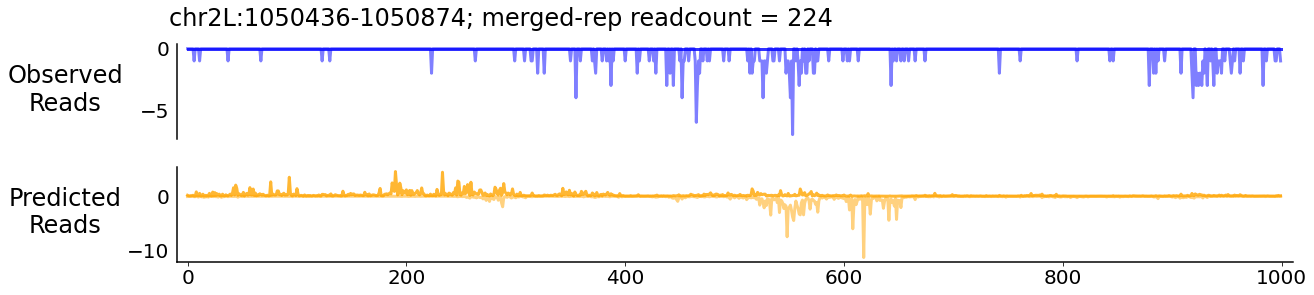

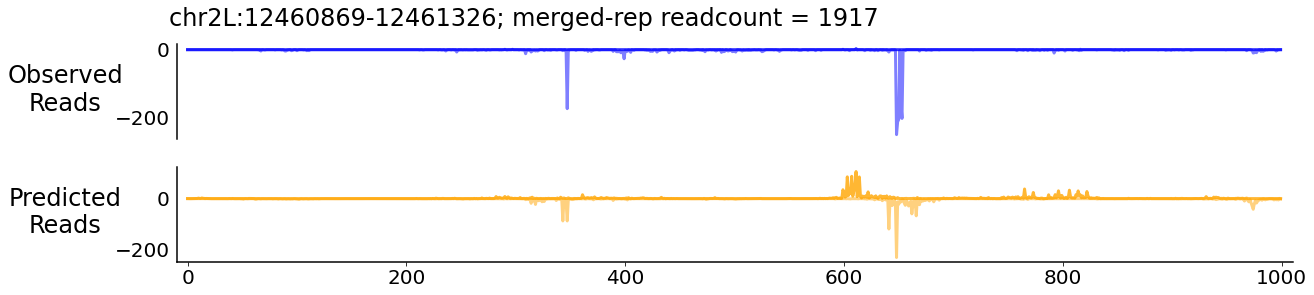

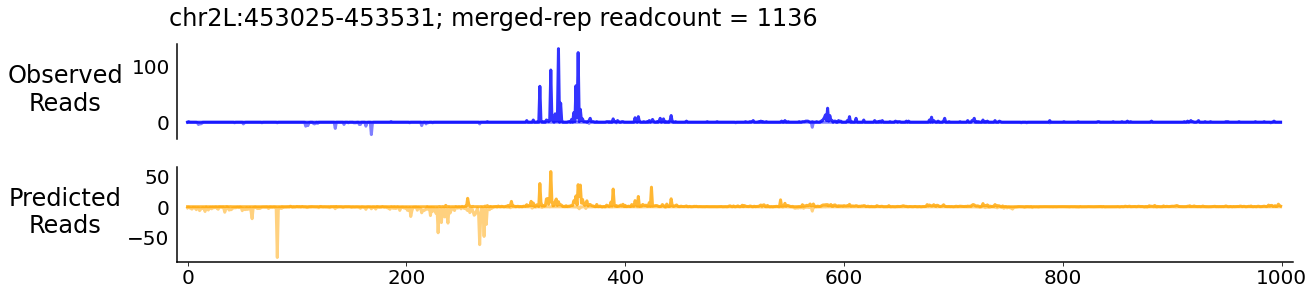

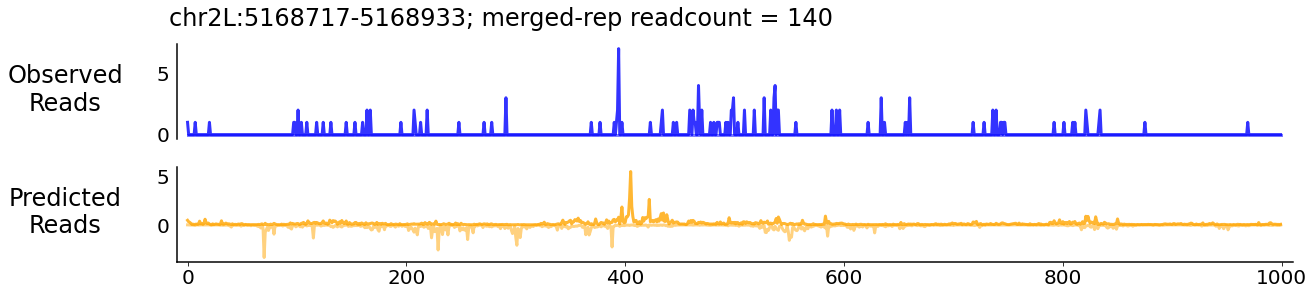

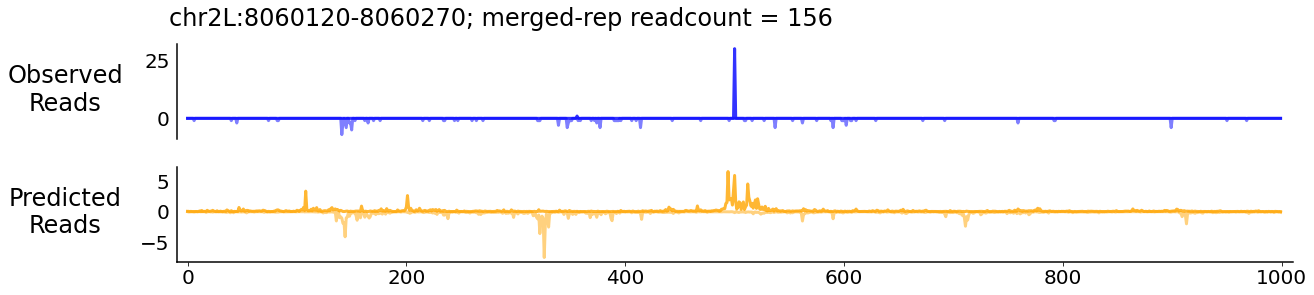

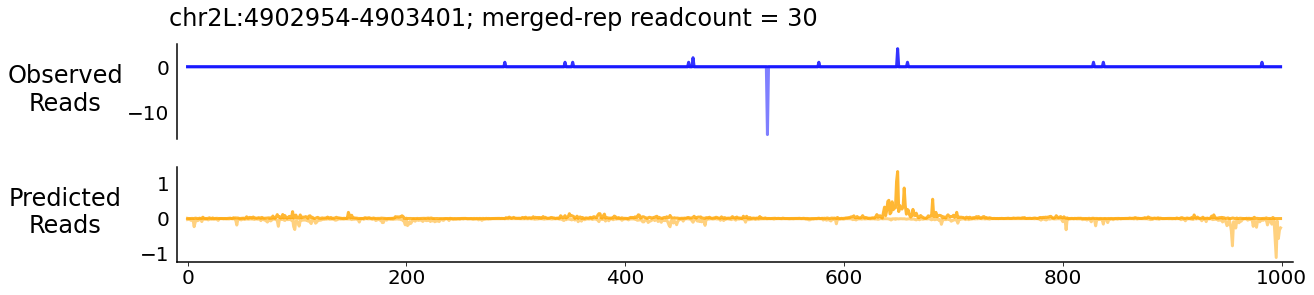

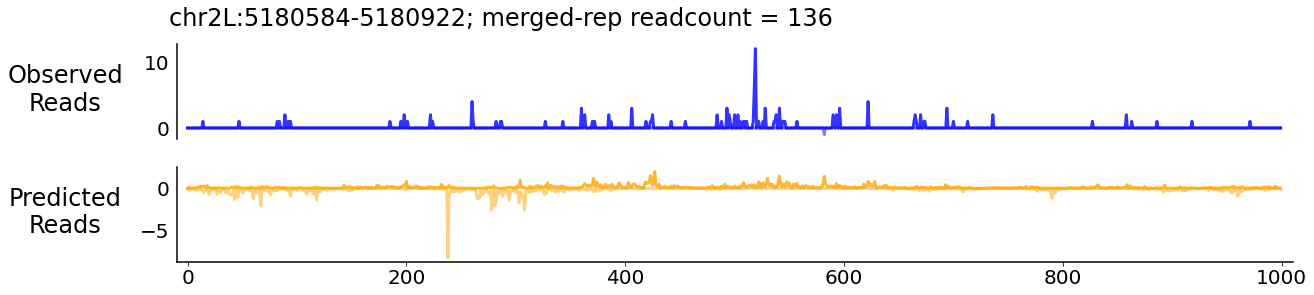

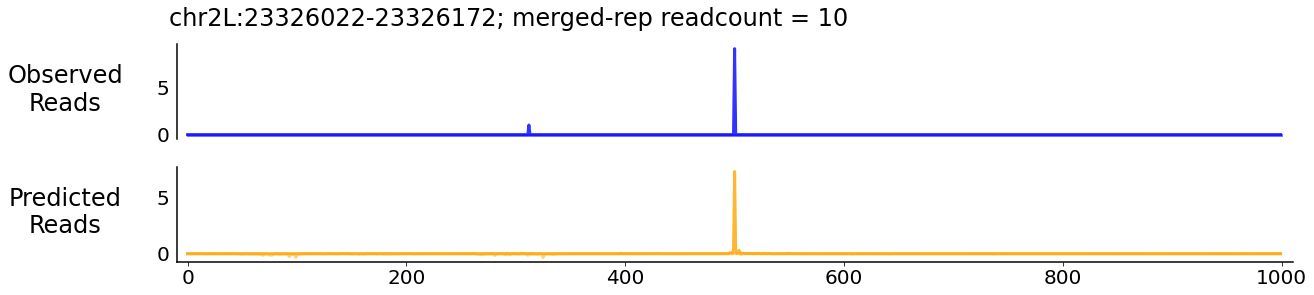

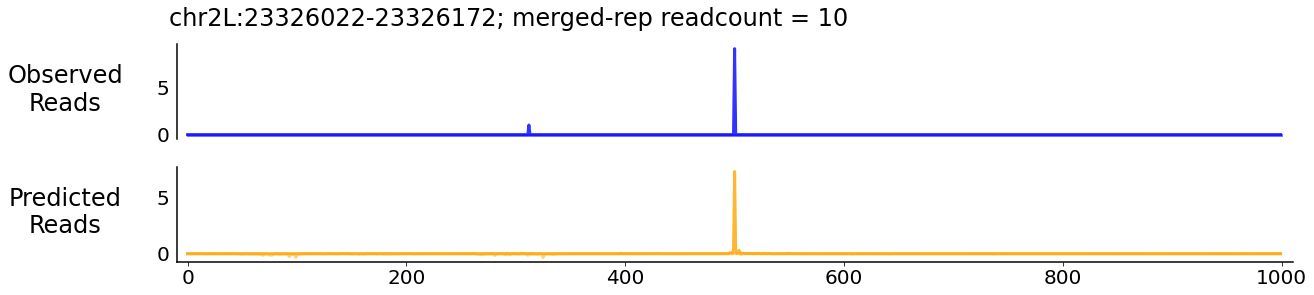

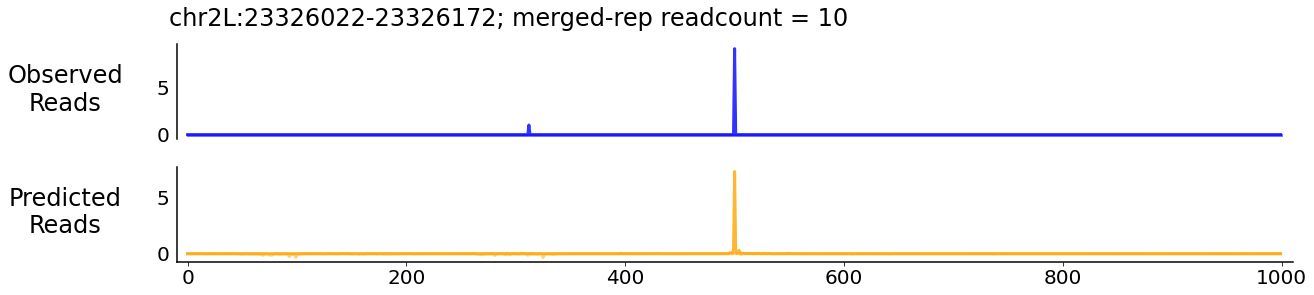

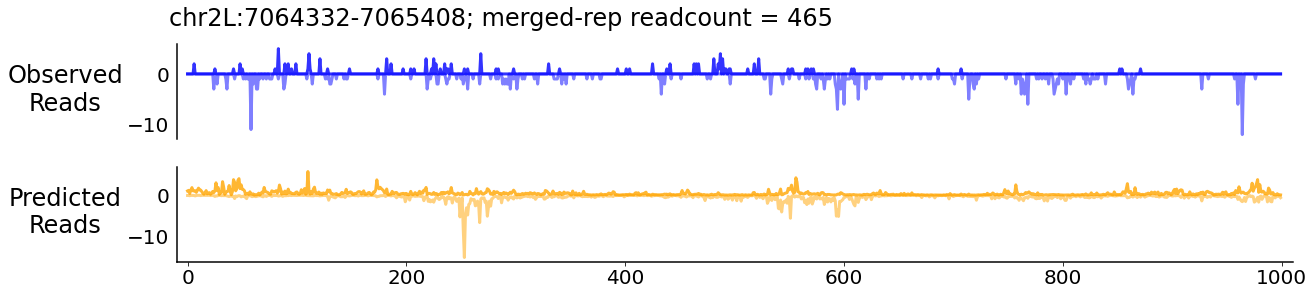

In [73]:
for idx in ex_idxs_jsd["top"]:
    true_profile = true_profiles[idx]
    true_count = numpy.sum(true_profile)
    
    title = coords[idx][0] + ":" + str(coords[idx][1]) + "-" + str(coords[idx][2])
    title += "; merged-rep readcount = " + str(int(true_count))
    
    pred_prof_scaled = true_count * pred_profiles[idx]

    plot_pred_vs_true(true_profile, pred_prof_scaled, title = title)

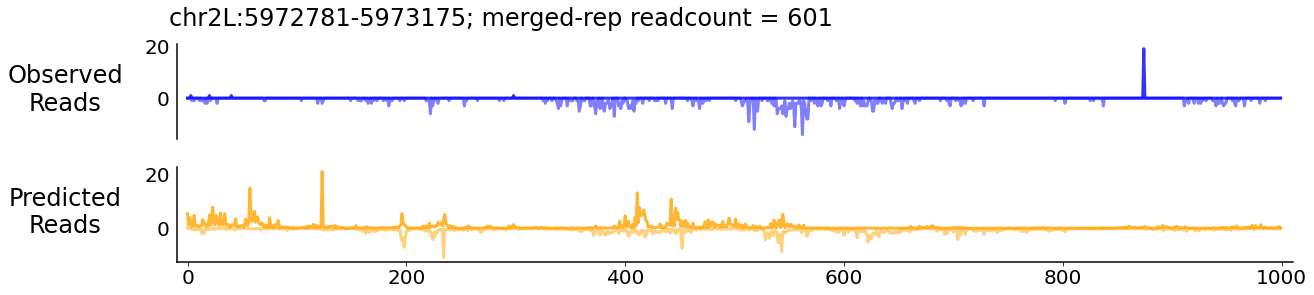

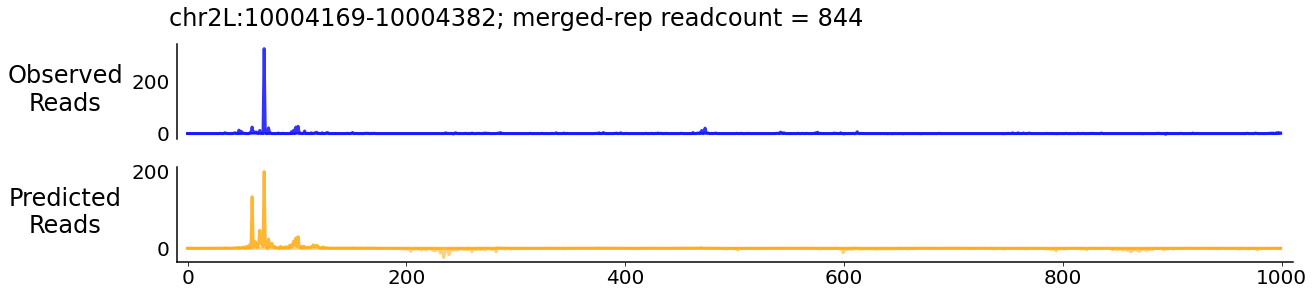

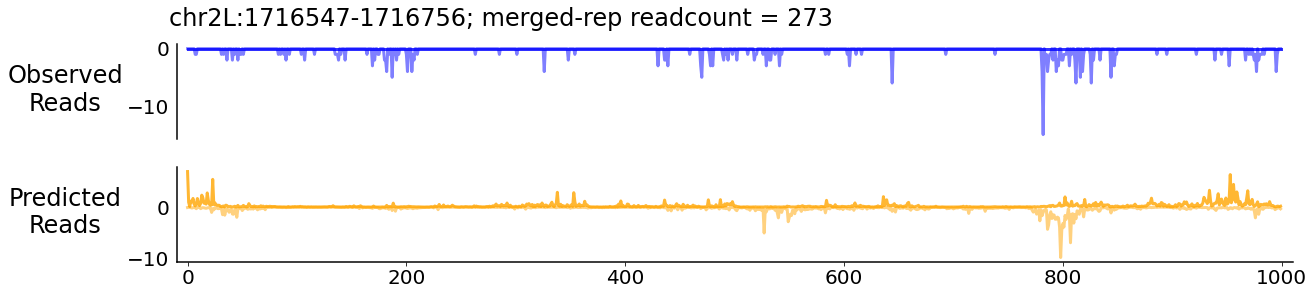

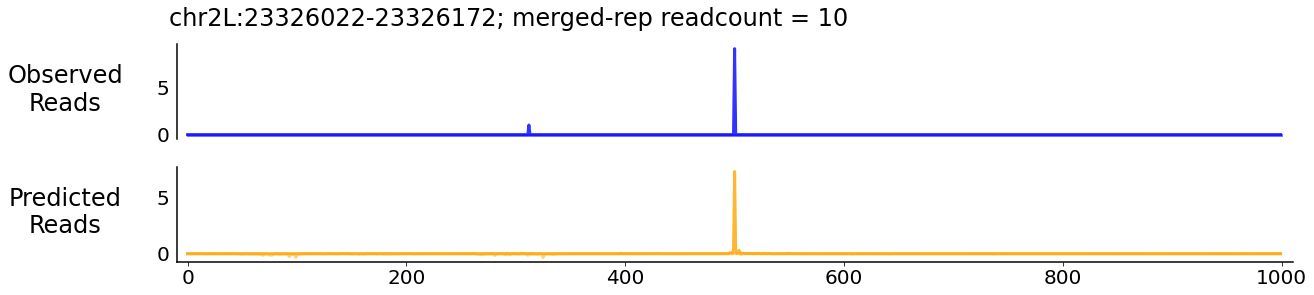

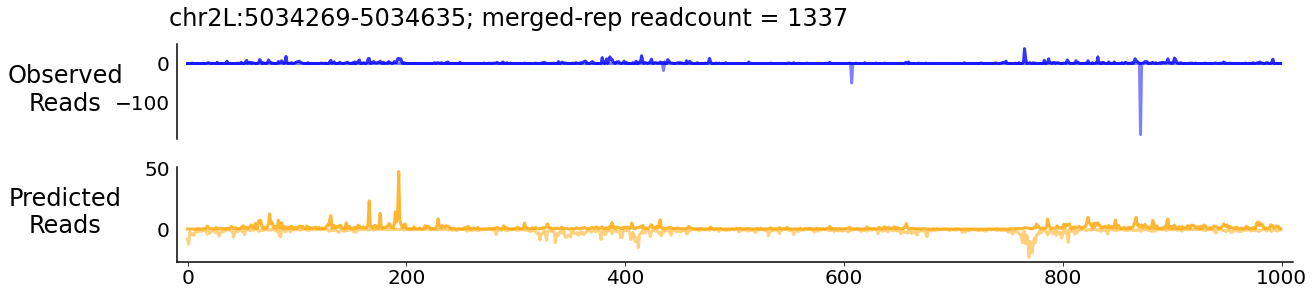

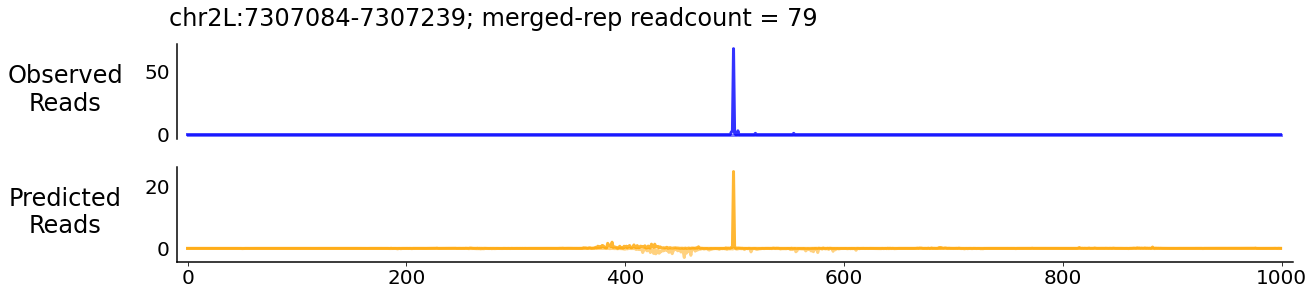

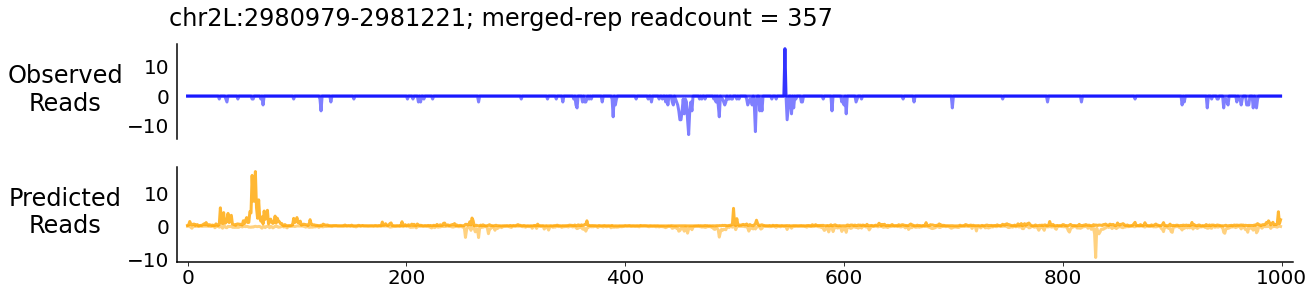

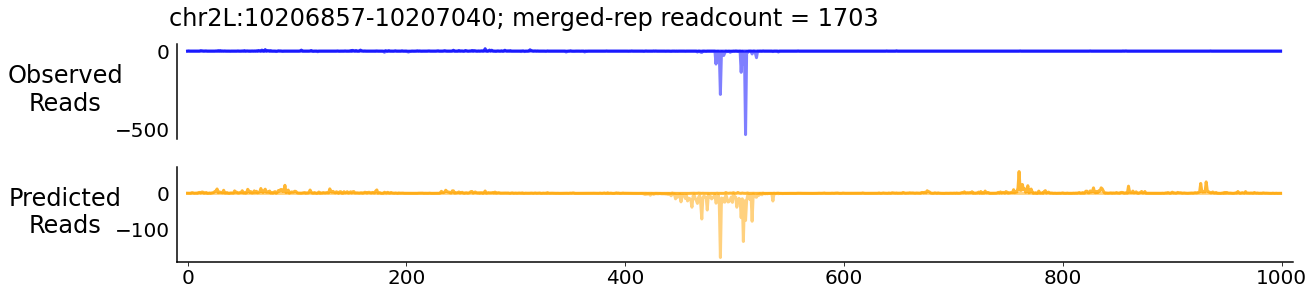

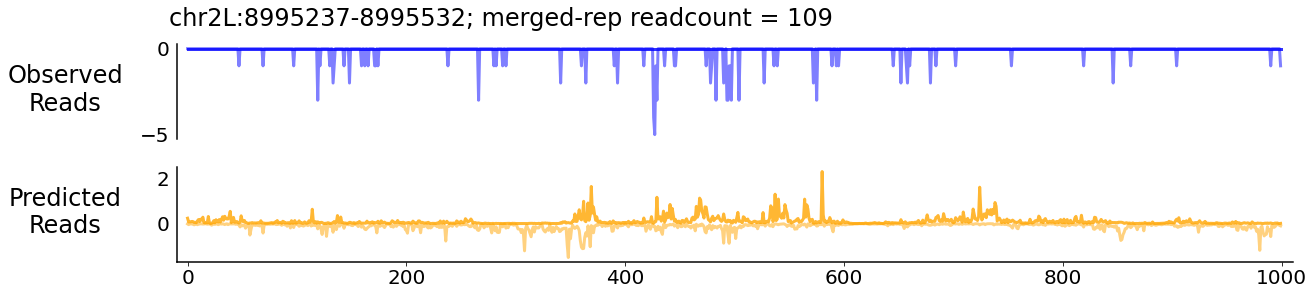

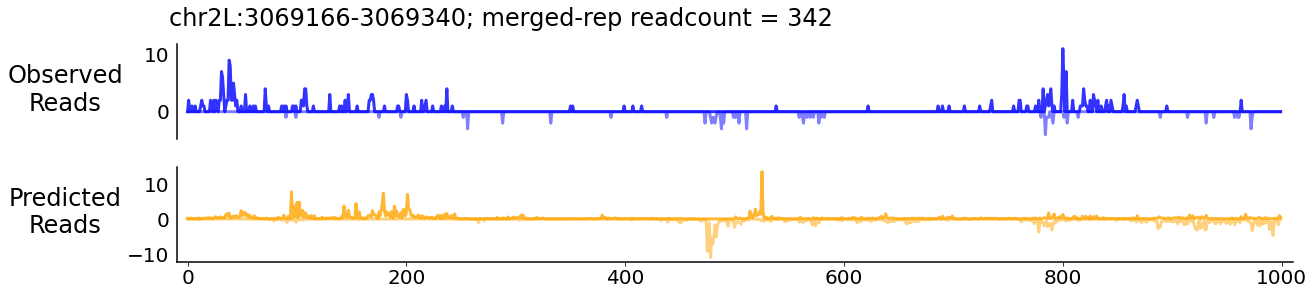

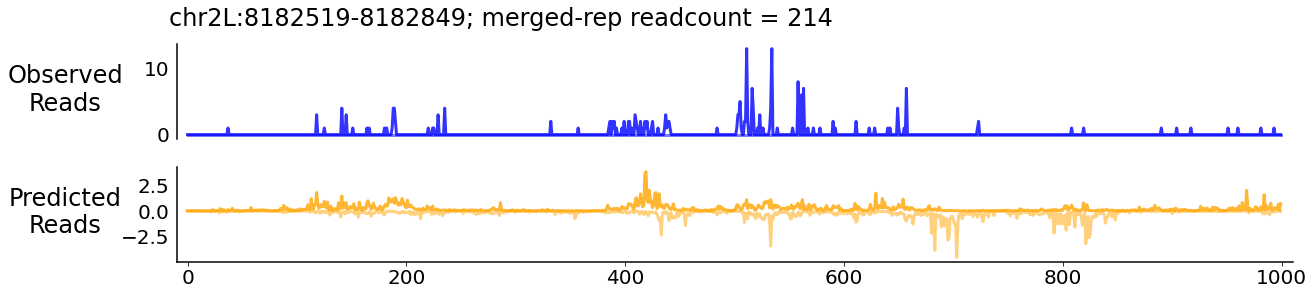

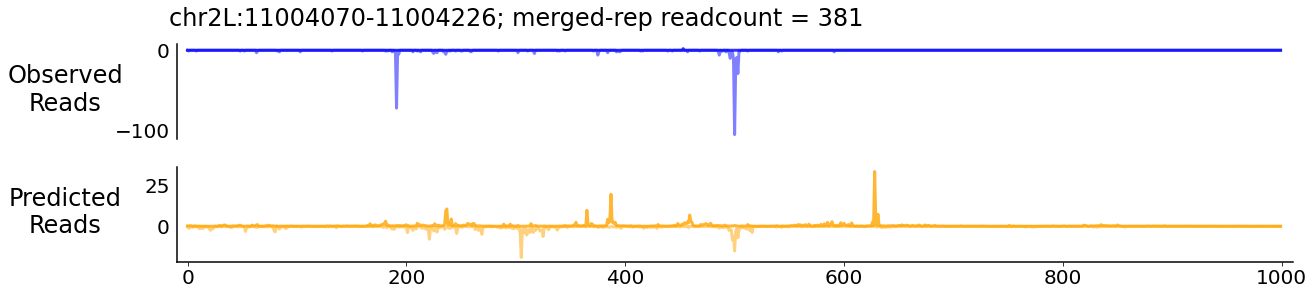

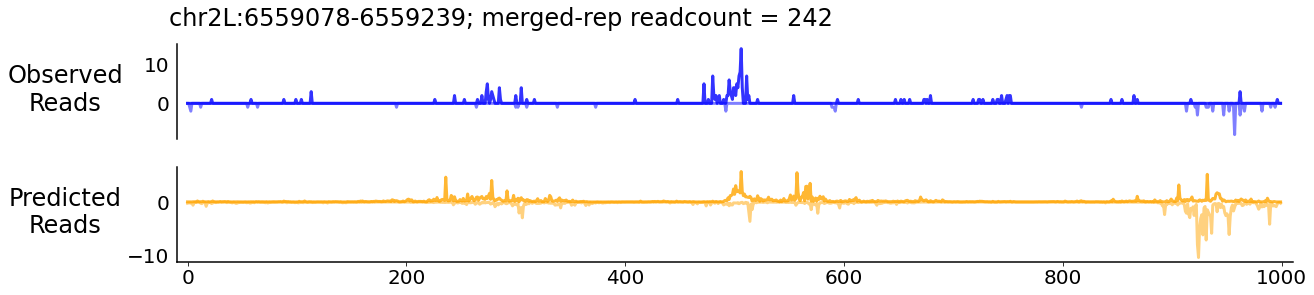

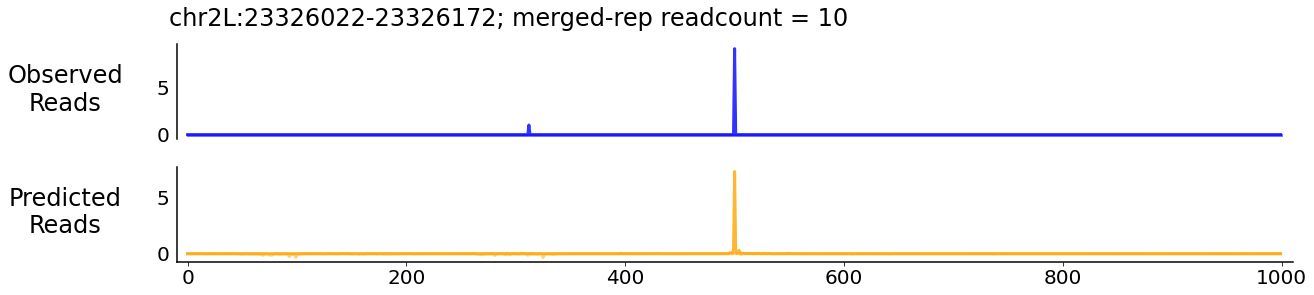

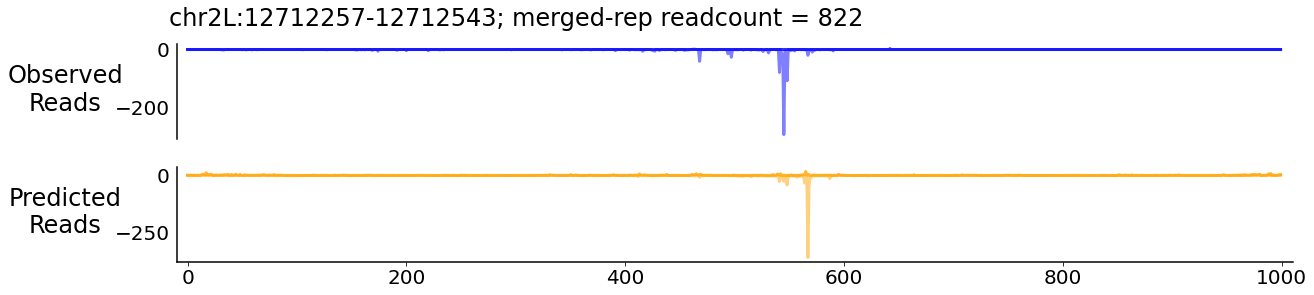

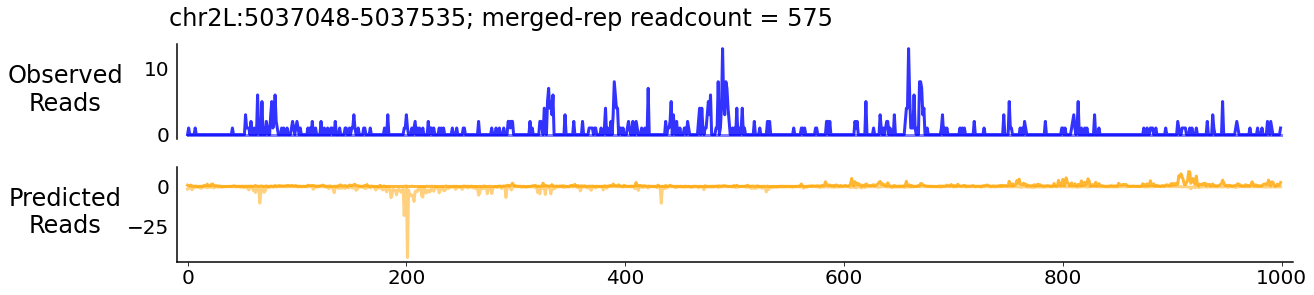

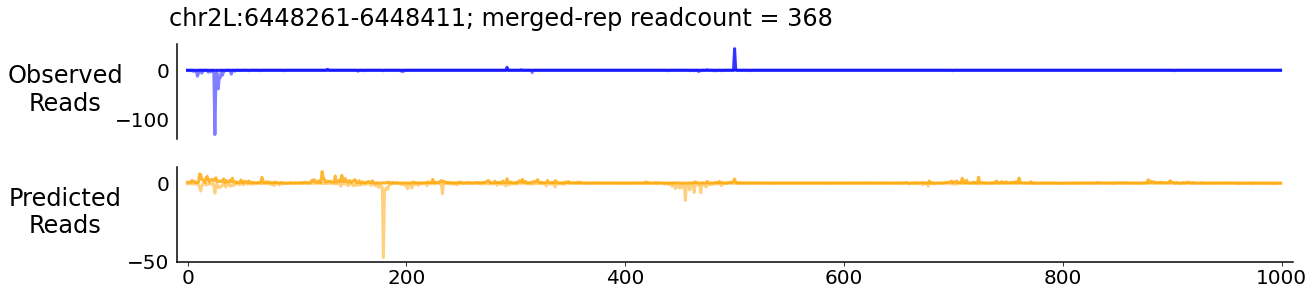

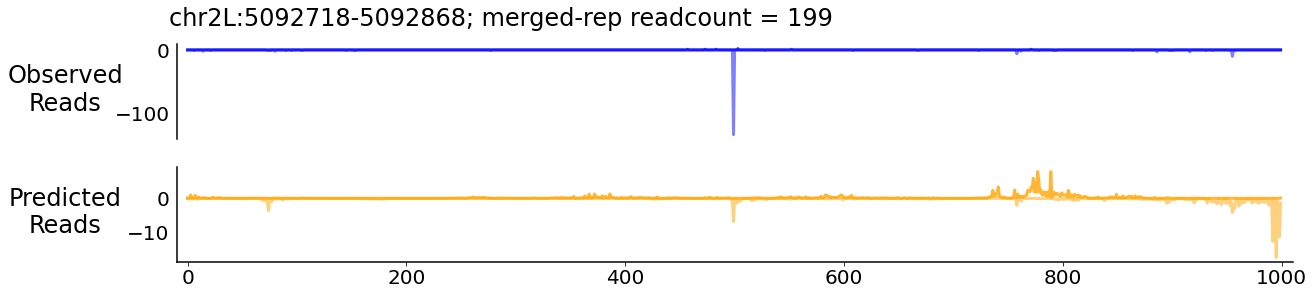

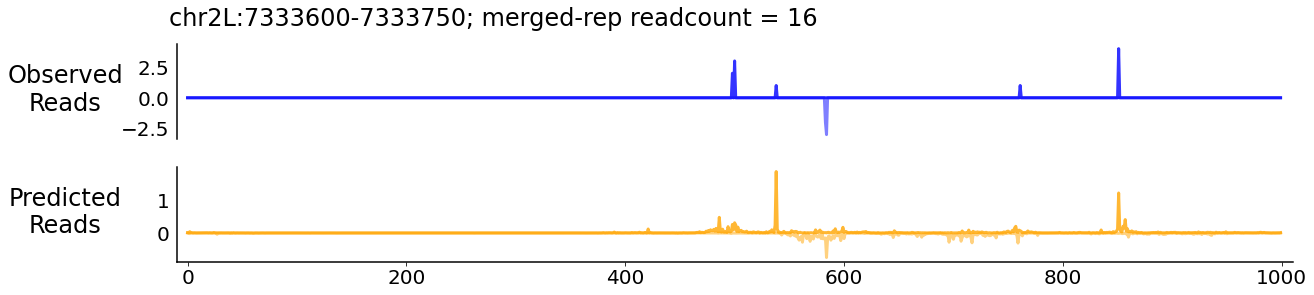

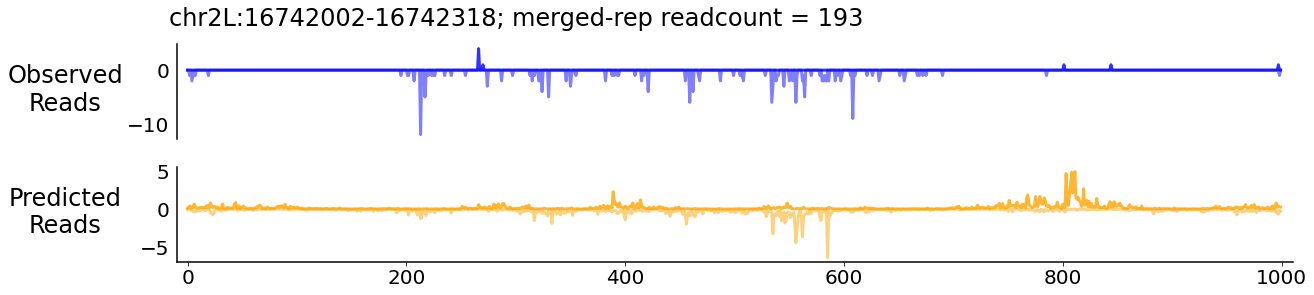

In [74]:
# Then plot some of the middling examples

for idx in ex_idxs_jsd["mid"]:
    true_profile = true_profiles[idx]
    true_count = numpy.sum(true_profile)
    
    title = coords[idx][0] + ":" + str(coords[idx][1]) + "-" + str(coords[idx][2])
    title += "; merged-rep readcount = " + str(int(true_count))
    
    pred_prof_scaled = true_count * pred_profiles[idx]

    plot_pred_vs_true(true_profile, pred_prof_scaled, title = title)

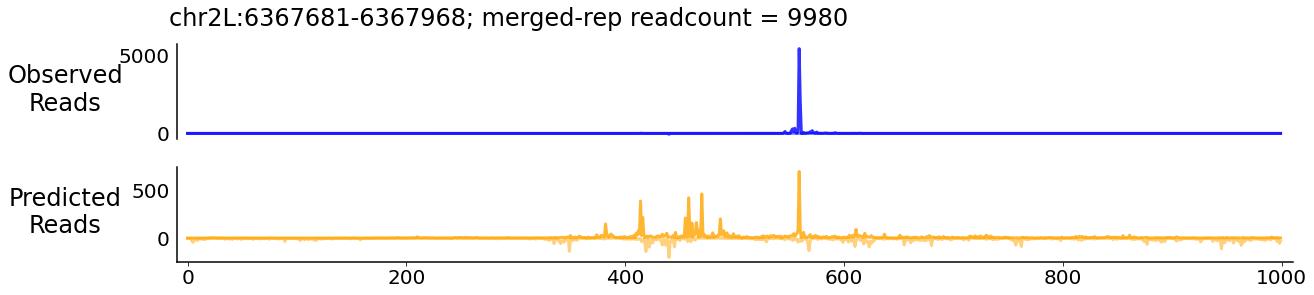

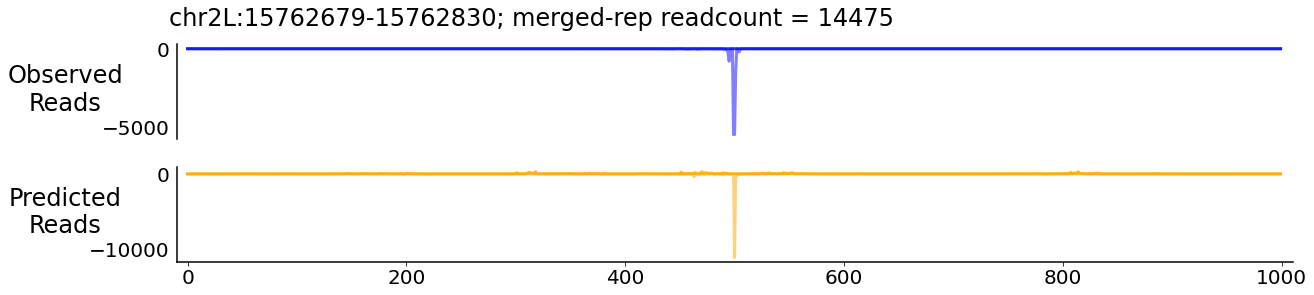

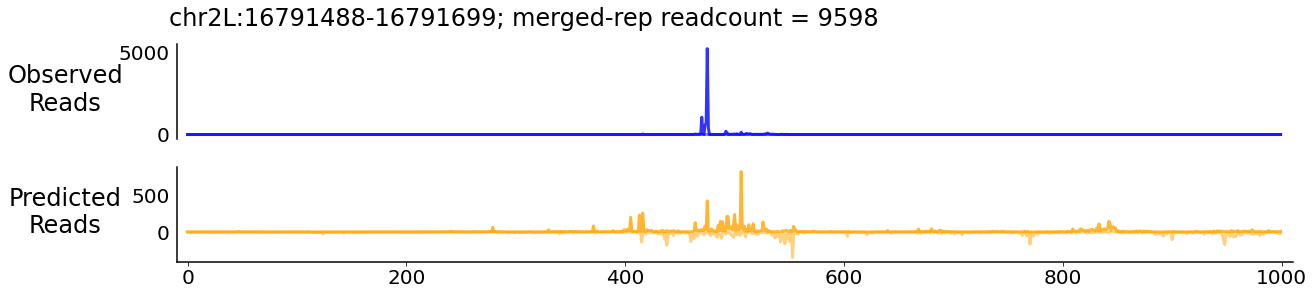

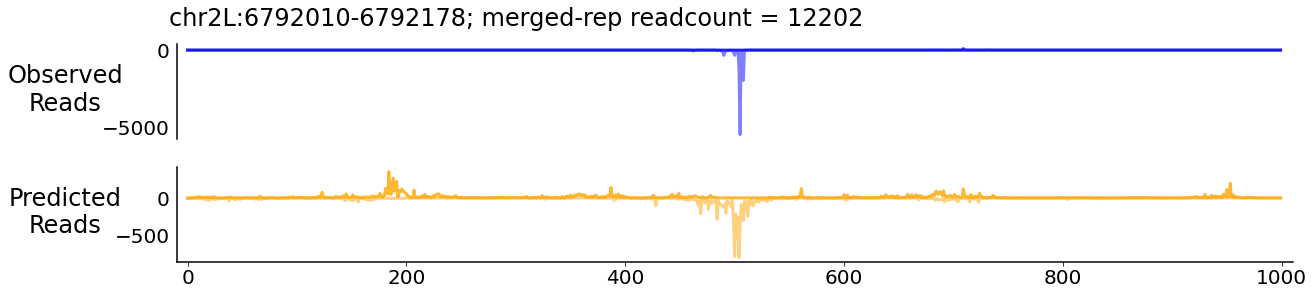

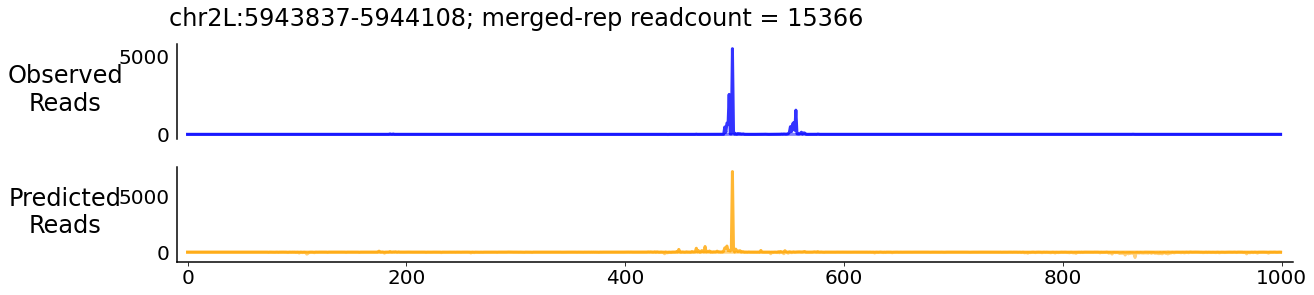

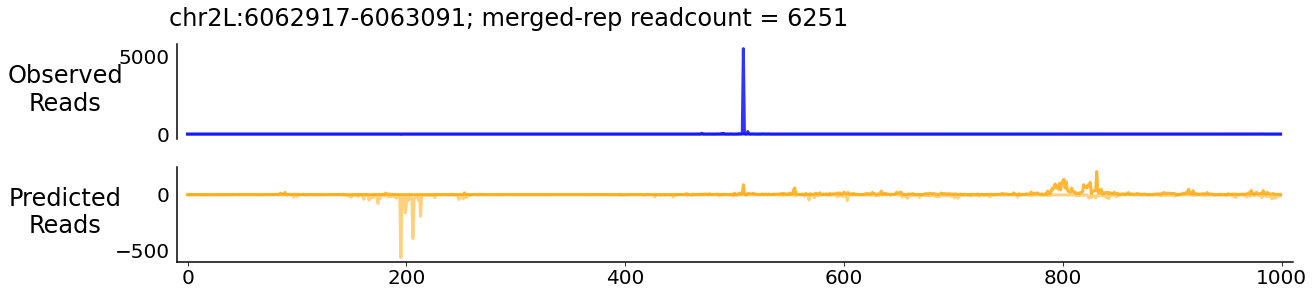

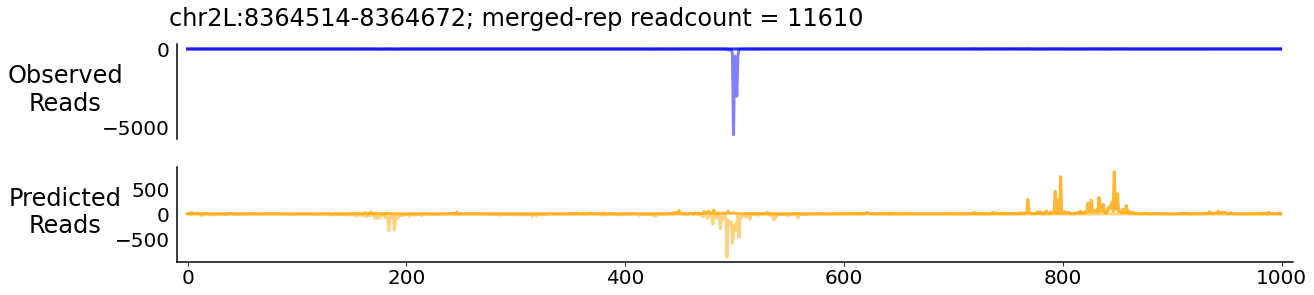

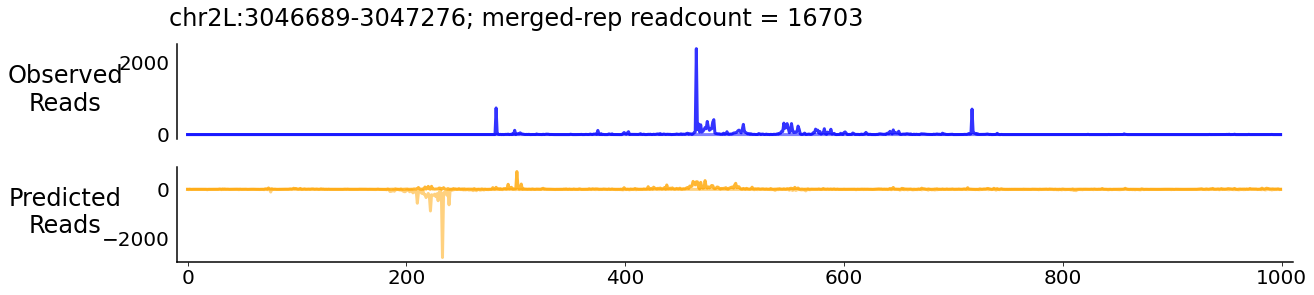

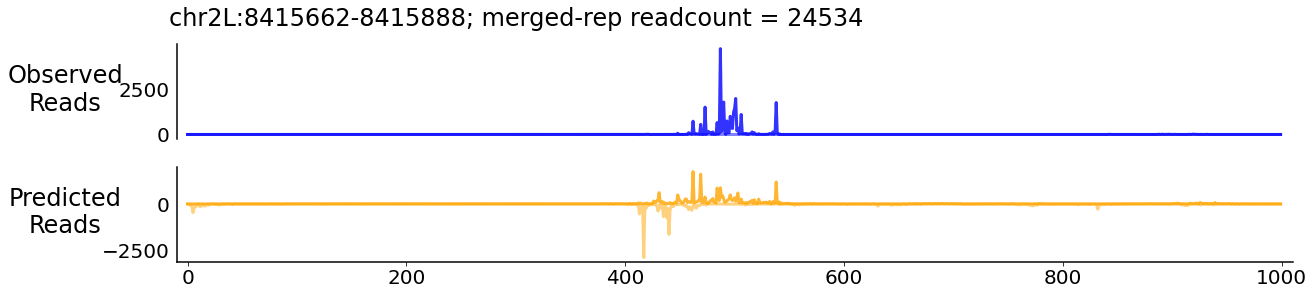

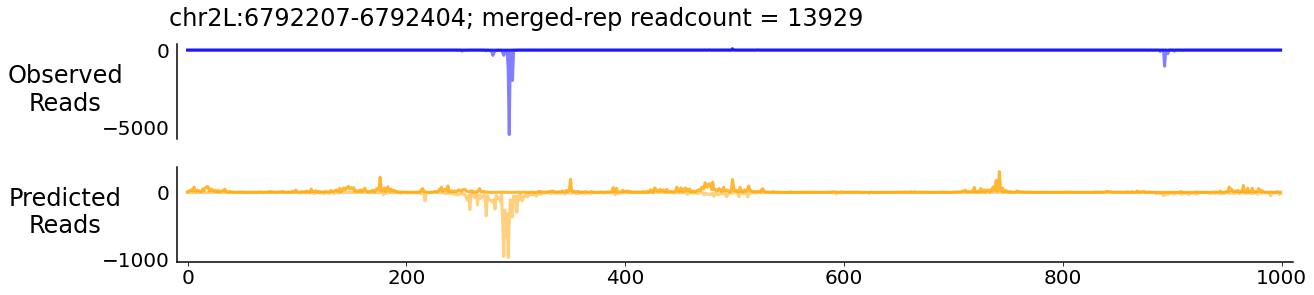

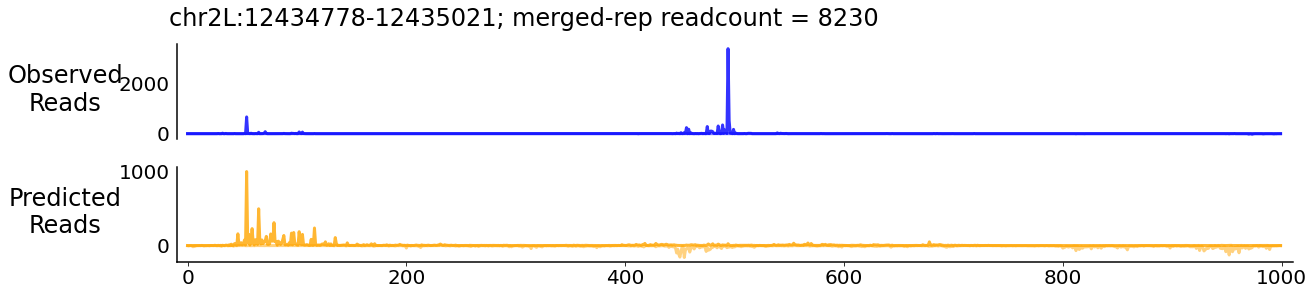

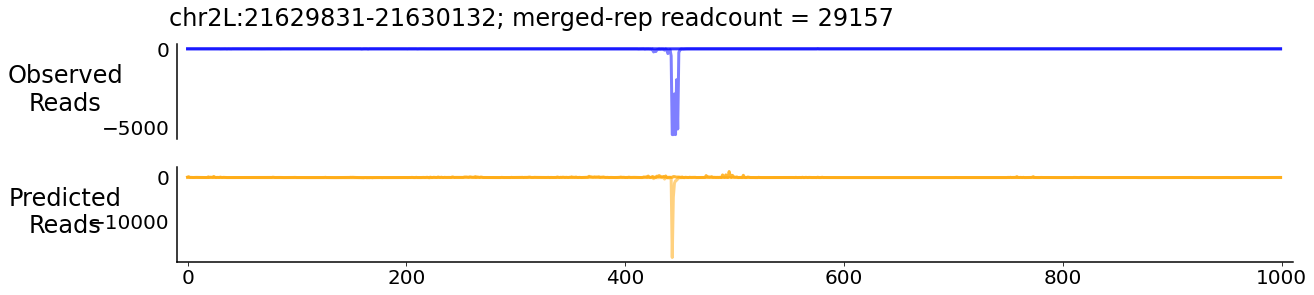

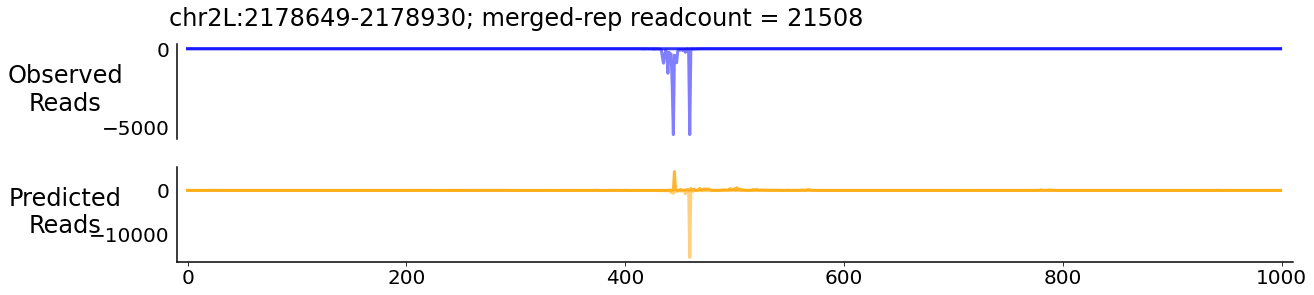

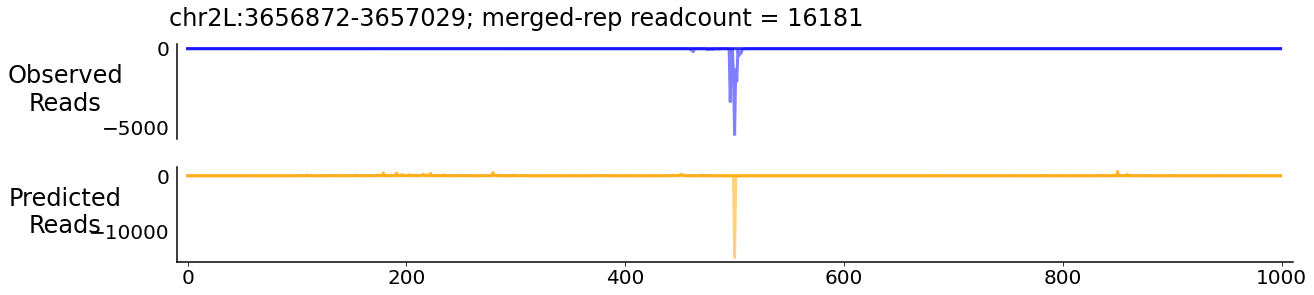

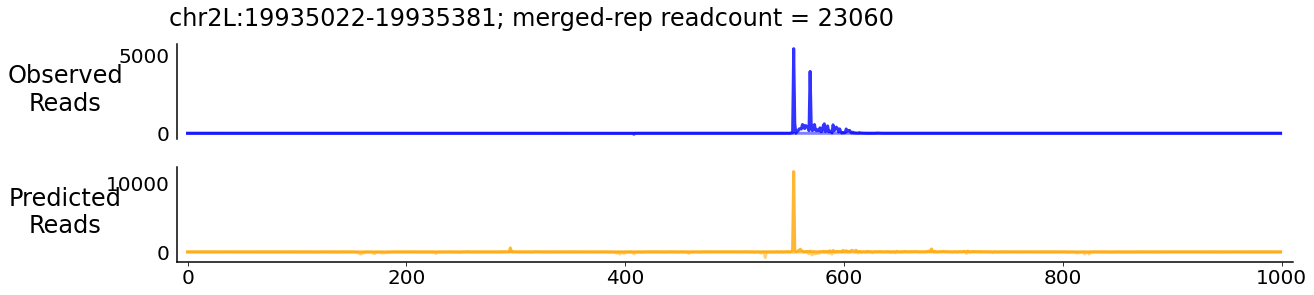

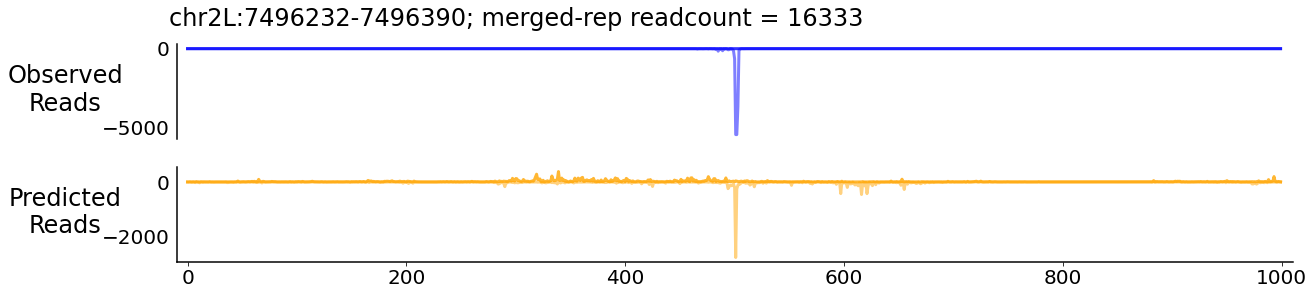

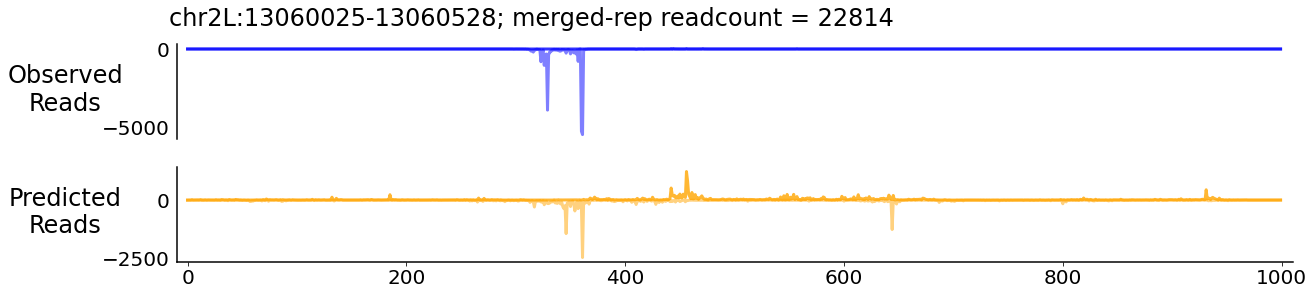

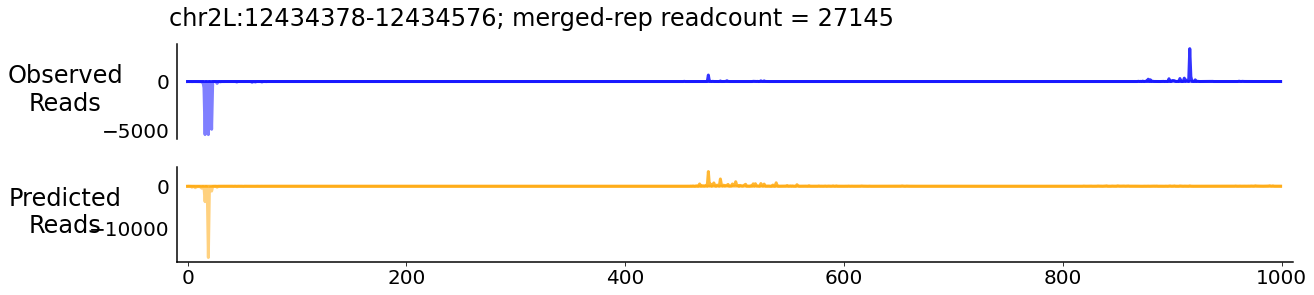

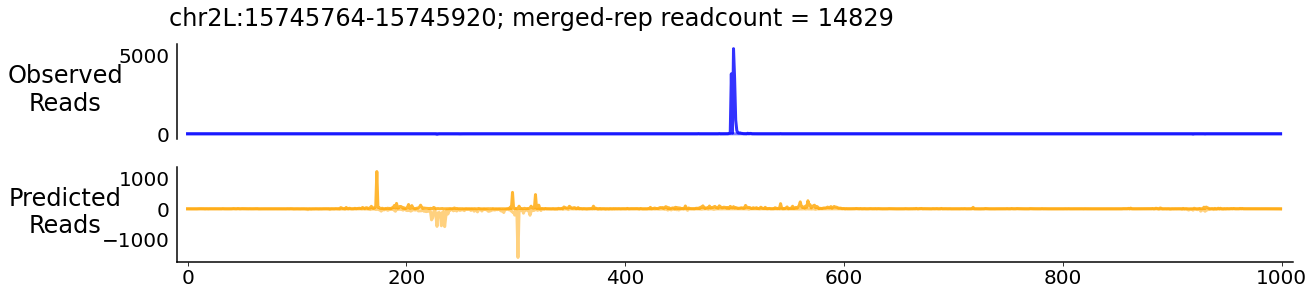

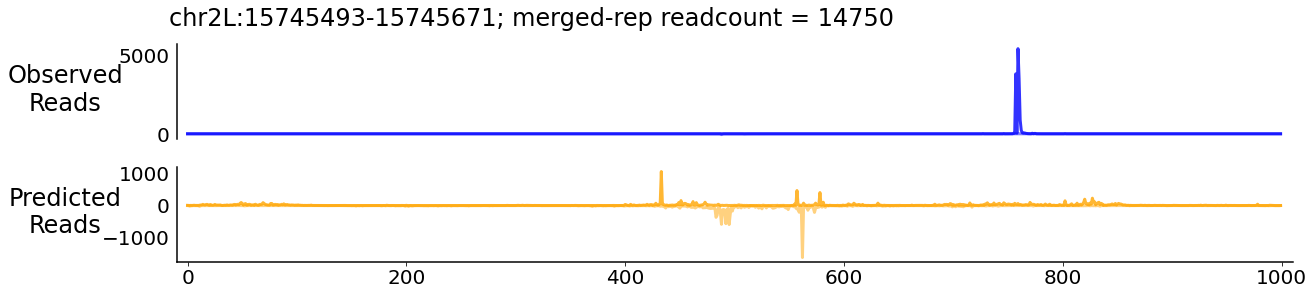

In [75]:
for idx in ex_idxs["bottom"]:
    true_profile = true_profiles[idx]
    true_count = numpy.sum(true_profile)
    
    title = coords[idx][0] + ":" + str(coords[idx][1]) + "-" + str(coords[idx][2])
    title += "; merged-rep readcount = " + str(int(true_count))
    
    pred_prof_scaled = true_count * pred_profiles[idx]

    plot_pred_vs_true(true_profile, pred_prof_scaled, title = title)